In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras import models, layers, Input
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
from ucimlrepo import fetch_ucirepo 

# Data

## Loading data

In [216]:
adult_data = fetch_ucirepo(id=2) 

In [217]:
adult_data.variables

name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                                          description units missing_values  
0                                                 N/A  None             no  
1   Private, Self-emp-not-inc, Self-emp-inc, Feder...  None            yes  
2                                                None  None             no  
3    Bachelors, Some-college, 11th, HS-grad, Prof-...  None             no  
4                                                None  None             no  
5   Married-civ-spouse, Divorced, Never-married, S...  None             no  
6   Tech-support, Craft-repair, Other-service, Sal...  None            yes  
7   Wife, Own-child, Husband, Not-in-family, Other...  None             no  
8   White, Asian-Pac-Islander, Amer-Indian-Eskimo,...  None             no  
9                                       Female, Male.  None             no  
10                                               None  None             no  
11                                               None  None             no  
12                                               None  None             no  
13  United-States, Cambodia, England, Puerto-Rico,...  None            yes  
14                                       >50K, <=50K.  None             no

# EDA

In [218]:
adult_data2 = adult_data.data.features
adult_data2['targets'] = adult_data.data.targets

In [219]:
adult_data2.describe()

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

In [220]:
adult_data2['targets'].value_counts()

targets
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

## Check values

In [221]:
for i in ['workclass', 'sex', 'education', 'occupation', 'marital-status', 'relationship', 'race', 'native-country']:
    print(i,':',getattr(adult_data2, i).unique(),'\n')

workclass : ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan] 

sex : ['Male' 'Female'] 

education : ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th'] 

occupation : ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv' nan] 

marital-status : ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed'] 

relationship : ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative'] 

race : ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other'] 

native-country : ['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puert

In [222]:
adult_data2.replace('?', None, inplace=True)

## Null handling

In [223]:
adult_data2.shape

(48842, 15)

In [224]:
adult_data2.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
targets              0
dtype: int64

Substitute nulls with mode

In [225]:
for i in ['workclass', 'occupation', 'native-country']:
    adult_data2.loc[adult_data2[i].isnull(),i] = adult_data2[i].mode()[0]

In [226]:
adult_data2.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
targets           0
dtype: int64

## Data comparison

with respect to income

Another thing worth noticing is the target. There seems to be a distinction between $<=50K$ and $<=50K.$, which is clearly an error. We correct it below

In [227]:
adult_data2.loc[:,'targets'] = adult_data2['targets'].replace(['<=50K.', '>50K.'], ['<=50K', '>50K'])

In [228]:
adult_data2['targets'].value_counts()

targets
<=50K    37155
>50K     11687
Name: count, dtype: int64

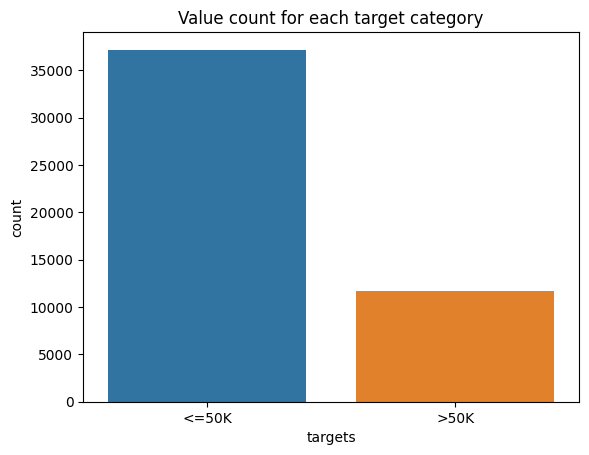

In [423]:
sns.countplot(adult_data2, x='targets')
plt.title('Value count for each target category')
plt.show()

It can be noted that there is a slight disproportion of values. Specifically there is visibly less people who's income exceedes $50$ K. However, samples for both income options have decent number of observations, so the analysis should still bring pretty good results. Disproportion itself is pretty natural, as one would expect that on average less people earn over $50$ K.

## Categorical data

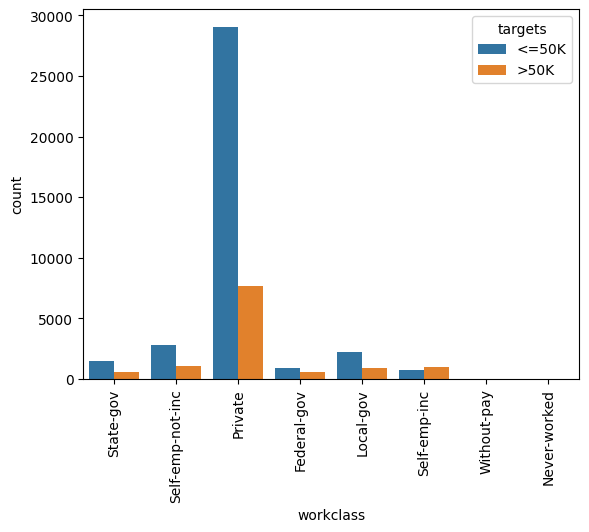

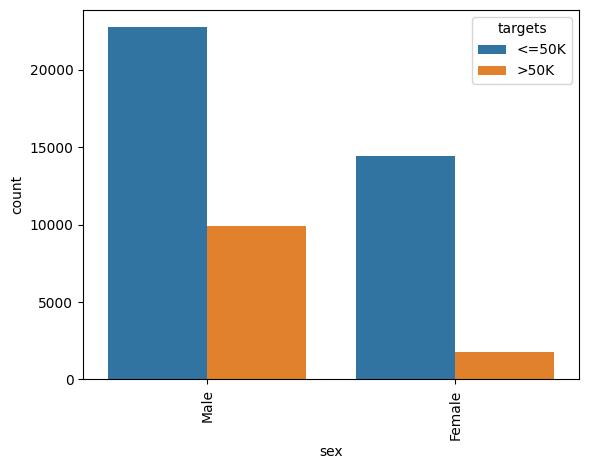

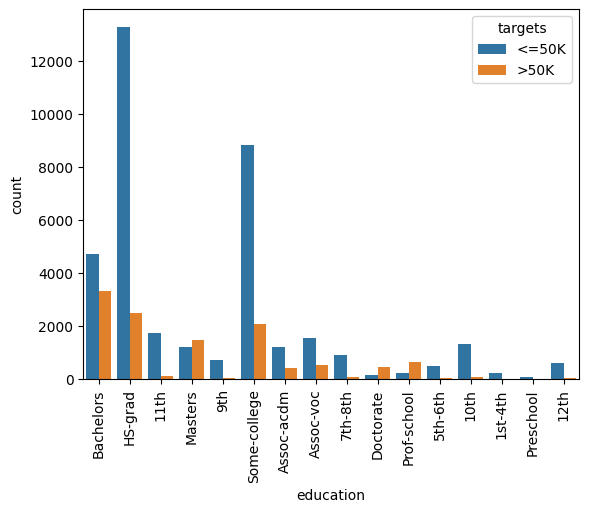

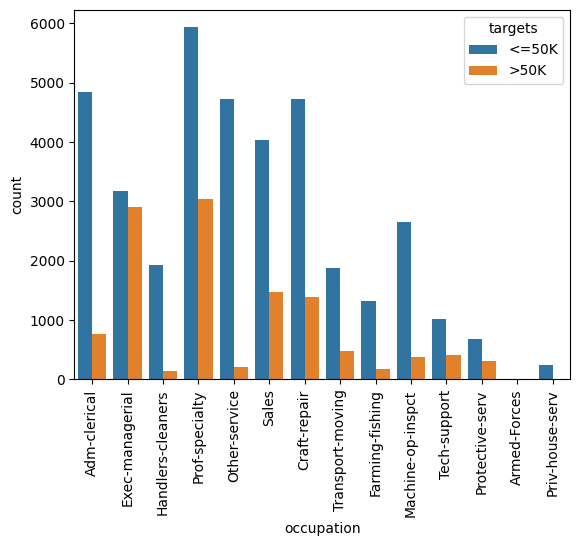

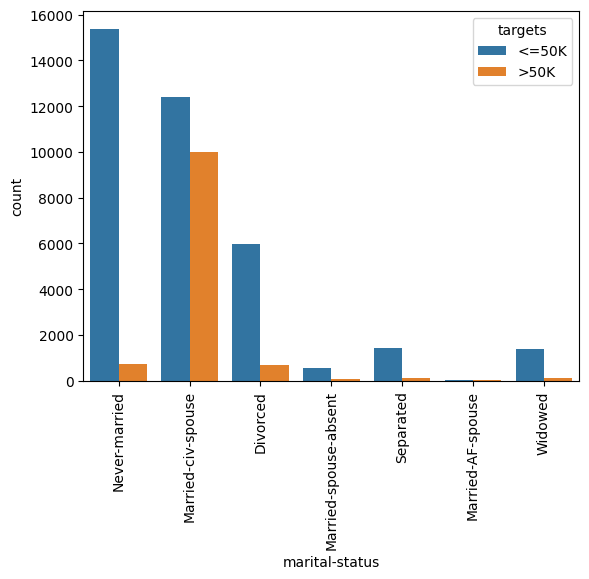

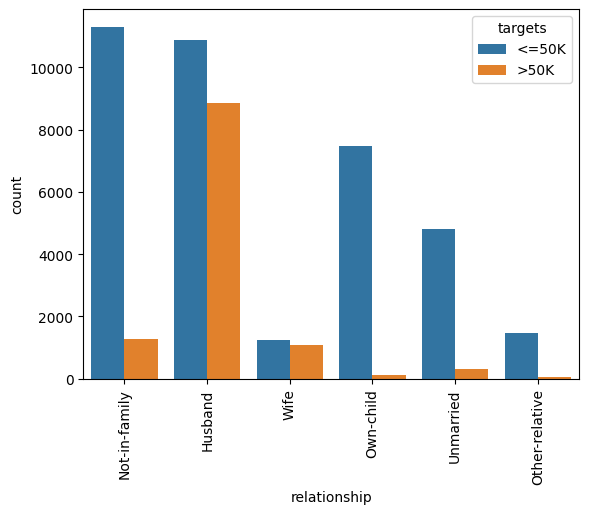

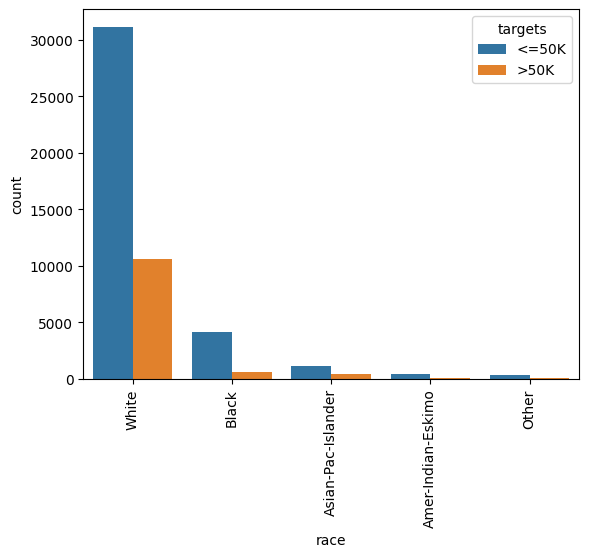

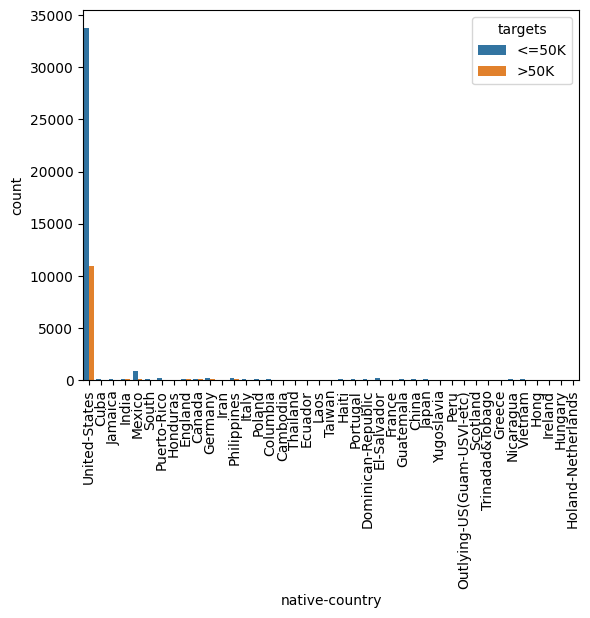

In [229]:
for i in ['workclass', 'sex', 'education', 'occupation', 'marital-status', 'relationship', 'race', 'native-country']:
    p = sns.countplot(adult_data2, x=i, hue='targets')
    plt.xticks(rotation=90)
    plt.show()

Based on these plots following features were ecluded from the model:
* race
* native-country

The decision was made based on the information that observations seem to be poorly balanced

In [230]:
adult_data2.drop(['race', 'native-country'], axis=1, inplace=True)

## Numerical data

In [231]:
np.isinf(adult_data2[['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']]).sum()

fnlwgt            0
education-num     0
capital-gain      0
capital-loss      0
hours-per-week    0
dtype: int64

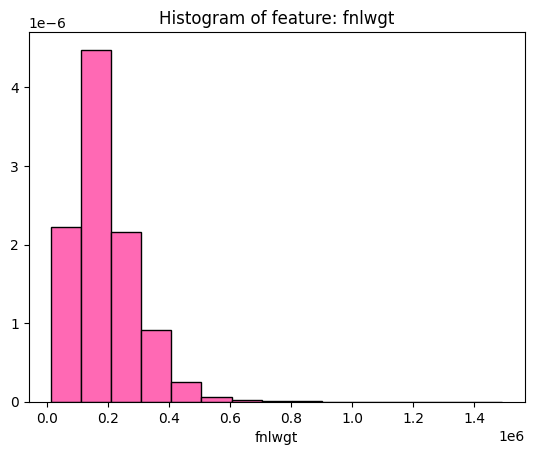

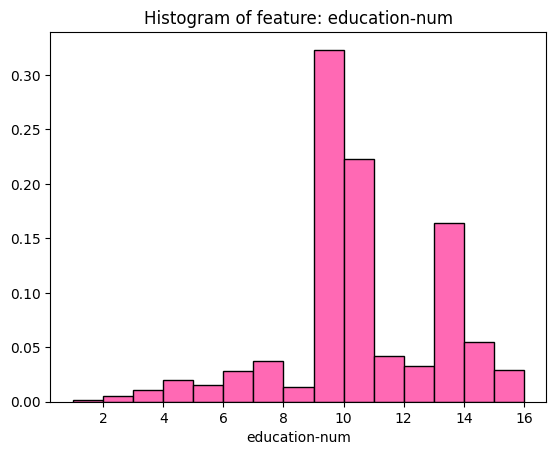

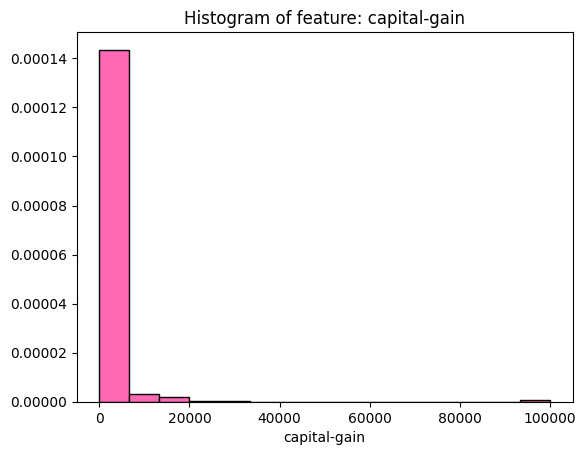

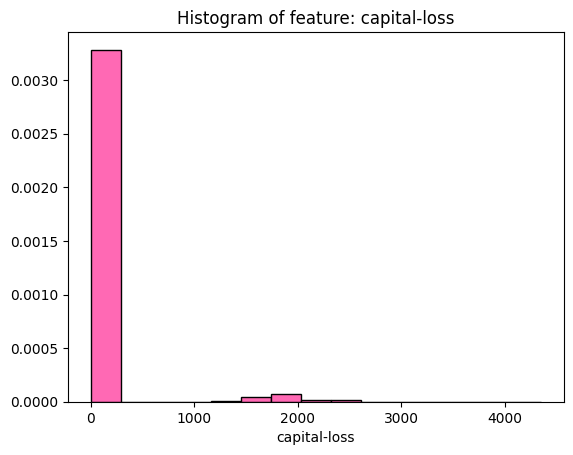

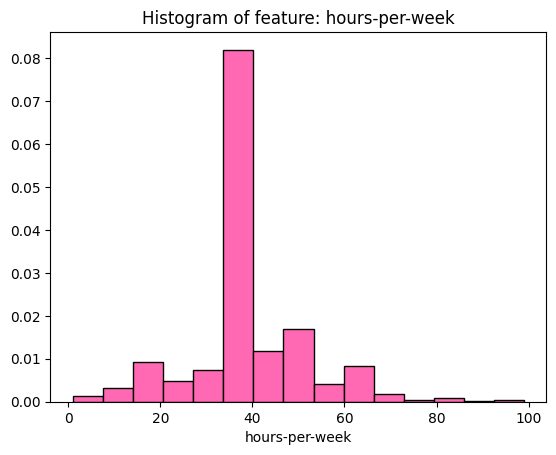

In [241]:
for i in ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']:
    plt.hist(adult_data2[i], density=True, bins=15, color='hotpink', edgecolor='black')
    plt.xlabel(i)
    plt.title(f'Histogram of feature: {i}')
    plt.show()

Histograms for capital-gain and capital-loss seem not to be helpful. In next step they will be considered in terms of their ability to distinguish between target categories.

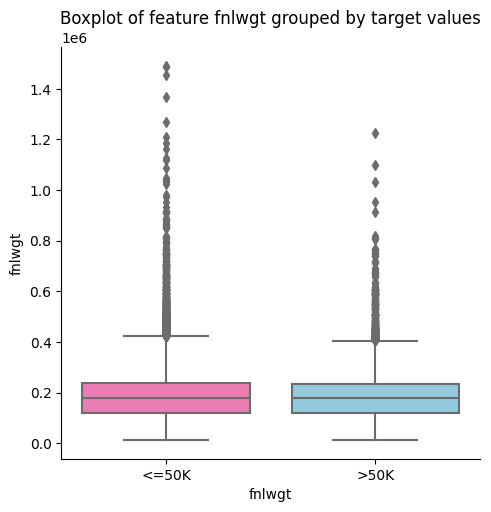

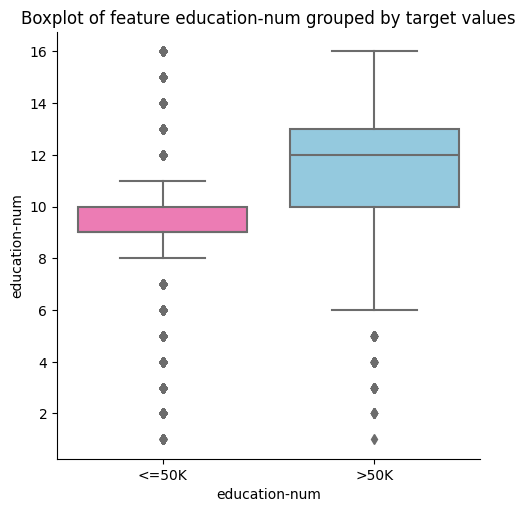

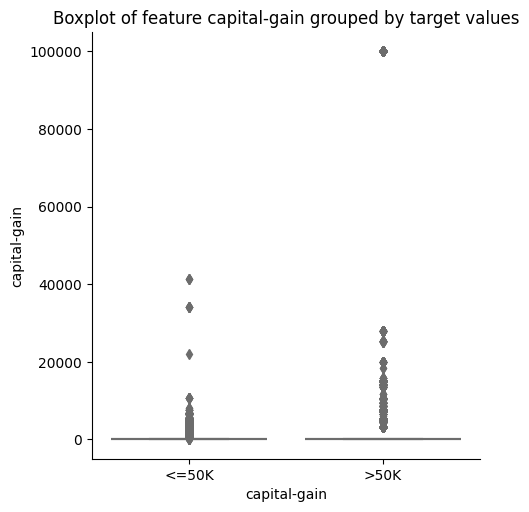

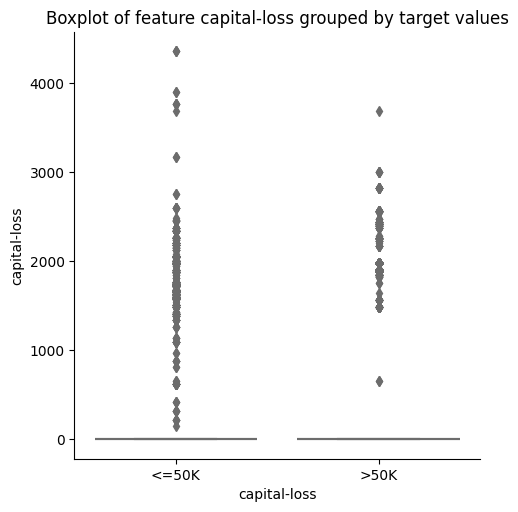

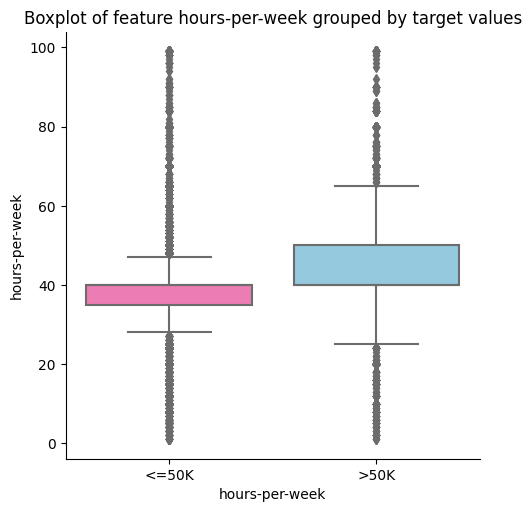

In [246]:
for i in ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']:
    p = sns.catplot(adult_data2, y=i, x='targets', kind='box', palette=['hotpink', 'skyblue'])
    plt.xlabel(i)
    plt.title(f'Boxplot of feature {i} grouped by target values')
    plt.show()

Based on these plots the following features were excluded:
* fnlwgt - it doesn't seem to be helpful in distinguishing between target groups
* capital-gain
* capital-loss

In [247]:
adult_data2.drop(['fnlwgt', 'capital-gain', 'capital-loss'], axis=1, inplace=True)

Additionally it's worth noticing that education-num brings very similar information as education. The decision was made to keep the discrete numerical variable (so education-num).

In [248]:
adult_data2.drop('education', axis=1, inplace=True)

In [249]:
adult_data2.columns

Index(['age', 'workclass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'sex', 'hours-per-week', 'targets'],
      dtype='object')

Next step is to prepare data to make a model. Therefore the categorical data was split into multiple columns in order to create binary attributes.

<i>At the end of this part base model was checked again but with normalized values for 'age', 'hours-per-week' and 'education-num', but there was no drastic change in results.</i>

In [266]:
base_data = adult_data2[['age', 'hours-per-week', 'education-num']]
split_sex = pd.get_dummies(adult_data2['sex'])
base_data.loc[:, split_sex.columns] = split_sex
split_occupation = pd.get_dummies(adult_data2['occupation'])
base_data.loc[:, split_occupation.columns] = split_occupation
split_workclass = pd.get_dummies(adult_data2['workclass'])
base_data.loc[:, split_workclass.columns] = split_workclass
split_marital = pd.get_dummies(adult_data2['marital-status'])
base_data.loc[:, split_marital.columns] = split_marital
split_relationship = pd.get_dummies(adult_data2['relationship'])
base_data.loc[:, split_relationship.columns] = split_relationship
target_data = adult_data2['targets']
np.random.seed(1234)
x_train, x_test, y_train, y_test = train_test_split(base_data*1, target_data*1)

In [267]:
x_train

age  hours-per-week  education-num  Female  Male  Adm-clerical  \
7704    56              25              9       1     0             0   
26501   52              40              1       0     1             0   
39467   50              50              9       0     1             0   
19450   44              55             14       0     1             0   
1815    22              40              9       0     1             0   
...    ...             ...            ...     ...   ...           ...   
32399   42              40             13       0     1             0   
17048   61              40             13       1     0             0   
23924   18              20              8       1     0             1   
34086   35              40              9       0     1             0   
27439   38              65             13       0     1             0   

       Armed-Forces  Craft-repair  Exec-managerial  Farming-fishing  ...  \
7704              0             0                0                0  ...   
26501             0             0                0                0  ...   
39467             0             0                0                0  ...   
19450             0             0                0                0  ...   
1815              0             0                0                0  ...   
...             ...           ...              ...              ...  ...   
32399             0             0                0                0  ...   
17048             0             0                1                0  ...   
23924             0             0                0                0  ...   
34086             0             1                0                0  ...   
27439             0             0                1                0  ...   

       Married-spouse-absent  Never-married  Separated  Widowed  Husband  \
7704                       0              0          0        1        0   
26501                      0              0          0        0        1   
39467                      0              0          0        0        1   
19450                      0              0          0        0        1   
1815                       0              1          0        0        0   
...                      ...            ...        ...      ...      ...   
32399                      0              0          0        0        1   
17048                      0              0          0        0        0   
23924                      0              1          0        0        0   
34086                      0              1          0        0        0   
27439                      0              0          0        0        1   

       Not-in-family  Other-relative  Own-child  Unmarried  Wife  
7704               0               0          0          1     0  
26501              0               0          0          0     0  
39467              0               0          0          0     0  
19450              0               0          0          0     0  
1815               0               0          1          0     0  
...              ...             ...        ...        ...   ...  
32399              0               0          0          0     0  
17048              0               0          0          0     1  
23924              0               0          1          0     0  
34086              0               1          0          0     0  
27439              0               0          0          0     0  

[36631 rows x 40 columns]

In [268]:
x_train.describe()

age  hours-per-week  education-num        Female  \
count  36631.000000    36631.000000   36631.000000  36631.000000   
mean      38.582021       40.399143      10.074691      0.331632   
std       13.729344       12.358530       2.585875      0.470806   
min       17.000000        1.000000       1.000000      0.000000   
25%       28.000000       40.000000       9.000000      0.000000   
50%       37.000000       40.000000      10.000000      0.000000   
75%       48.000000       45.000000      12.000000      1.000000   
max       90.000000       99.000000      16.000000      1.000000   

               Male  Adm-clerical  Armed-Forces  Craft-repair  \
count  36631.000000  36631.000000  36631.000000  36631.000000   
mean       0.668368      0.116377      0.000328      0.124294   
std        0.470806      0.320681      0.018097      0.329921   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000   

       Exec-managerial  Farming-fishing  ...  Married-spouse-absent  \
count     36631.000000     36631.000000  ...           36631.000000   
mean          0.123393         0.030575  ...               0.012885   
std           0.328892         0.172166  ...               0.112781   
min           0.000000         0.000000  ...               0.000000   
25%           0.000000         0.000000  ...               0.000000   
50%           0.000000         0.000000  ...               0.000000   
75%           0.000000         0.000000  ...               0.000000   
max           1.000000         1.000000  ...               1.000000   

       Never-married     Separated       Widowed      Husband  Not-in-family  \
count   36631.000000  36631.000000  36631.000000  36631.00000   36631.000000   
mean        0.332096      0.030875      0.030903      0.40291       0.258060   
std         0.470972      0.172983      0.173057      0.49049       0.437573   
min         0.000000      0.000000      0.000000      0.00000       0.000000   
25%         0.000000      0.000000      0.000000      0.00000       0.000000   
50%         0.000000      0.000000      0.000000      0.00000       0.000000   
75%         1.000000      0.000000      0.000000      1.00000       1.000000   
max         1.000000      1.000000      1.000000      1.00000       1.000000   

       Other-relative     Own-child     Unmarried          Wife  
count    36631.000000  36631.000000  36631.000000  36631.000000  
mean         0.030084      0.156179      0.105348      0.047419  
std          0.170820      0.363030      0.307005      0.212536  
min          0.000000      0.000000      0.000000      0.000000  
25%          0.000000      0.000000      0.000000      0.000000  
50%          0.000000      0.000000      0.000000      0.000000  
75%          0.000000      0.000000      0.000000      0.000000  
max          1.000000      1.000000      1.000000      1.000000  

[8 rows x 40 columns]

In [269]:
print('train shape:',x_train.shape)
print('test shape:',x_test.shape)

train shape: (36631, 40)
test shape: (12211, 40)


# Model creation

In [270]:
x_train = np.asarray(x_train).reshape((36631, 40)).astype('float32')
x_test = np.array(x_test).reshape((12211, 40)).astype('float32')

In [271]:
y_train = np.asarray(pd.get_dummies(y_train)).astype(float)
y_test = np.asarray(pd.get_dummies(y_test)).astype(float)

In [272]:
x_train

array([[56., 25.,  9., ...,  0.,  1.,  0.],
       [52., 40.,  1., ...,  0.,  0.,  0.],
       [50., 50.,  9., ...,  0.,  0.,  0.],
       ...,
       [18., 20.,  8., ...,  1.,  0.,  0.],
       [35., 40.,  9., ...,  0.,  0.,  0.],
       [38., 65., 13., ...,  0.,  0.,  0.]], dtype=float32)

## Base model
With two layers: 
 - first having 128 neurons and activation function relu
 - second with 2 neurons and activation function softmax

As a base optimizer rmsprop was taken. Loss function - categorical crossentropy. And as a comparison metrics - accuracy.

In [261]:
model = models.Sequential()
model.add(Input(shape=(40,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [30]:
model_adult = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7690 - loss: 0.5656 - val_accuracy: 0.8251 - val_loss: 0.3708
Epoch 2/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8149 - loss: 0.3919 - val_accuracy: 0.8282 - val_loss: 0.3767
Epoch 3/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8217 - loss: 0.3786 - val_accuracy: 0.8329 - val_loss: 0.3585
Epoch 4/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8251 - loss: 0.3697 - val_accuracy: 0.8221 - val_loss: 0.3731
Epoch 5/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8259 - loss: 0.3688 - val_accuracy: 0.8171 - val_loss: 0.3725
Epoch 6/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8307 - loss: 0.3569 - val_accuracy: 0.8351 - val_loss: 0.3535
Epoch 7/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8310 - loss: 0.3561 - val_accuracy: 0.8308 - val_loss: 0.3603
Epoch 8/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8295 - loss: 0

In [36]:
# np.save('base_model_train_acc', model_adult.history['accuracy'])
# np.save('base_model_train_loss', model_adult.history['loss'])
# np.save('base_model_test_acc', model_adult.history['val_accuracy'])
# np.save('base_model_test_loss', model_adult.history['val_loss'])

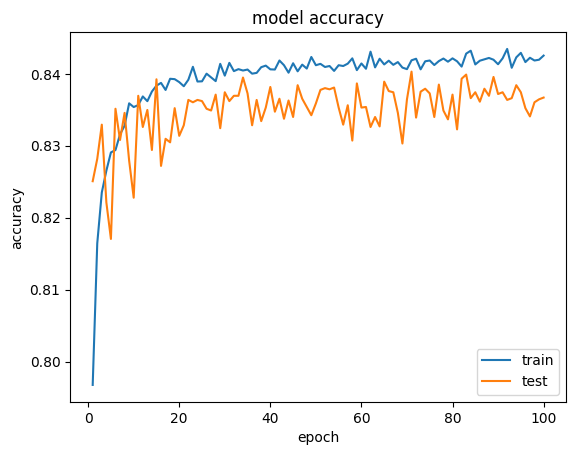

In [37]:
plt.plot(range(1,101),model_adult.history['accuracy'])
plt.plot(range(1,101), model_adult.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

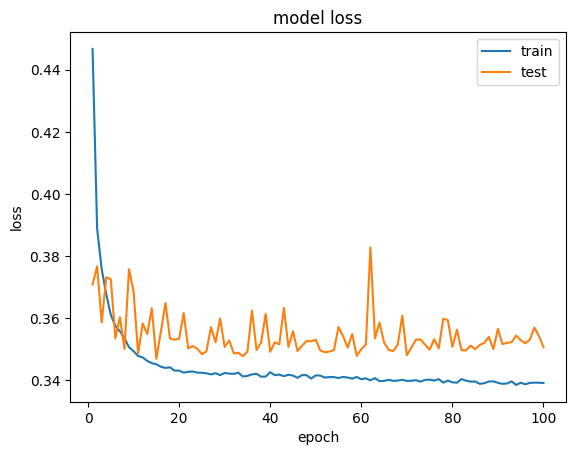

In [38]:
plt.plot(range(1,101), model_adult.history['loss'])
plt.plot(range(1,101), model_adult.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

Based on these two plots model for trained values seems to be getting better in time. At the very beggining it's also the case for the test set. In this specific example both accuracy and loss for test set seem to be stabilizing after 20 epochs. However, obtained results are just exemplary, therefore a conclusion that more epochs may lead to overfitting cannot be fully drawn - gives an idea for further analysis.

# Test number of epochs

In [263]:
def get_model_base():
    model_optimizer = models.Sequential()
    model_optimizer.add(Input(shape=(40,)))
    model_optimizer.add(layers.Dense(128, activation='relu'))
    model_optimizer.add(layers.Dense(2, activation='softmax'))
    model_optimizer.compile(optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
    return model_optimizer

In [275]:
n = 40
m = 10
train_acc = np.zeros((n,m))
test_acc = np.zeros((n,m))
train_loss = np.zeros((n,m))
test_loss = np.zeros((n,m))
for j in range(m):
    temp_model1 = get_model_base()
    temp_model = temp_model1.fit(x_train, y_train, epochs=n, validation_data=(x_test, y_test))
    train_acc[:,j] = temp_model.history['accuracy']
    test_acc[:,j] = temp_model.history['val_accuracy']
    train_loss[:,j] = temp_model.history['loss']
    test_loss[:,j] = temp_model.history['val_loss']
    print(f'ROUND {j}')

Epoch 1/40
  33/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6731 - loss: 0.8985

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7798 - loss: 0.4786 - val_accuracy: 0.7840 - val_loss: 0.4353
Epoch 2/40
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8143 - loss: 0.3950 - val_accuracy: 0.7661 - val_loss: 0.5243
Epoch 3/40
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8264 - loss: 0.3726 - val_accuracy: 0.8306 - val_loss: 0.3567
Epoch 4/40
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8258 - loss: 0.3701 - val_accuracy: 0.8116 - val_loss: 0.3831
Epoch 5/40
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8278 - loss: 0.3634 - val_accuracy: 0.8345 - val_loss: 0.3559
Epoch 6/40
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8296 - loss: 0.3591 - val_accuracy: 0.8328 - val_loss: 0.3503
Epoch 7/40
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8282 - loss: 0.3608 - val_accuracy: 0.8339 - val_loss: 0.3554
Epoch 8/40
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8304 - loss: 0.3611 - val_accura

In [278]:
# np.save('eee_train_acc', train_acc)
# np.save('eee_train_loss', train_loss)
# np.save('eee_test_acc', test_acc)
# np.save('eee_test_loss', test_loss)

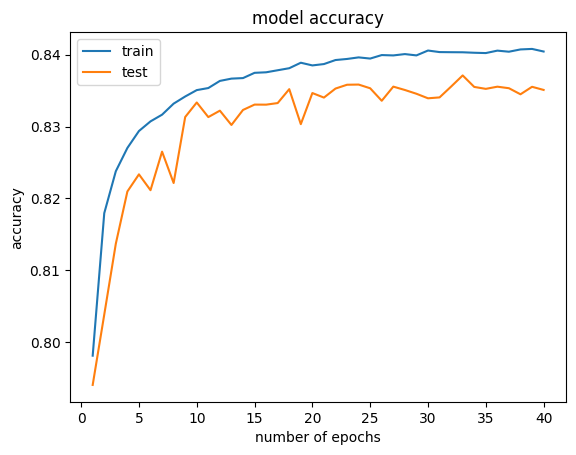

In [277]:
plt.plot(range(1, n+1), train_acc.mean(axis=1))
plt.plot(range(1, n+1), test_acc.mean(axis=1))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('number of epochs')
plt.legend(['train', 'test'])
plt.show()

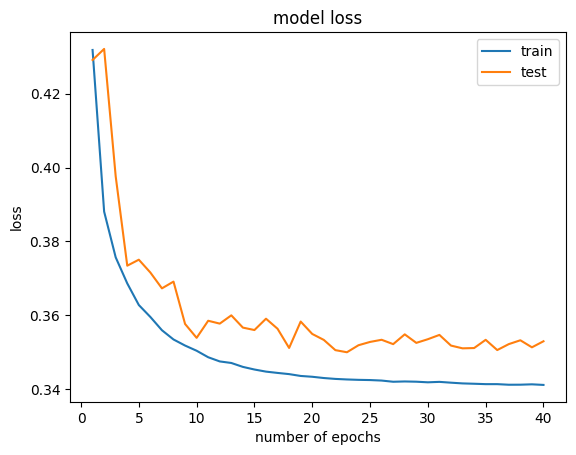

In [279]:
plt.plot(range(1, n+1), train_loss.mean(axis=1))
plt.plot(range(1, n+1), test_loss.mean(axis=1))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('number of epochs')
plt.legend(['train', 'test'])
plt.show()

Here, as expected, model gets better with longer learning time. However learing takes time. Therefore the optimal number of epochs was chosen. Specifically, it can be seen that around 20th epoch model stabilizes on both plots for test set.

As for the the question set before: whether we can assume that with more time there will be overfitting of the model. Looking at the plot there's nothing suggesting that the overfitting will occur. Some differences between train and test set results are noticible but, at least for chosen number of epochs, not significant. This issue would require further consideration.

# Test activation functions

In [303]:
def get_model_activ_func(func_name: str):
    model_activ_func = models.Sequential()
    model_activ_func.add(Input(shape=(40,)))
    model_activ_func.add(layers.Dense(128, activation=func_name))
    model_activ_func.add(layers.Dense(2, activation='softmax'))
    model_activ_func.compile(optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
    return model_activ_func

In [304]:
m=10
en=5
train_acc_f = np.zeros((5,en))
test_acc_f = np.zeros((5,en))
train_loss_f = np.zeros((5,en))
test_loss_f = np.zeros((5,en))
k=0
activ_func_list = ['relu', 'softmax', 'sigmoid', 'exponential', 'linear']
for i in activ_func_list:
    ttrain_acc_f = np.zeros((en,m))
    ttest_acc_f = np.zeros((en,m))
    ttrain_loss_f = np.zeros((en,m))
    ttest_loss_f = np.zeros((en,m))
    for j in range(m):
        temp_model1 = get_model_activ_func(i)
        temp_model = temp_model1.fit(x_train, y_train, epochs=en, validation_data=(x_test, y_test))
        ttrain_acc_f[:,j] = temp_model.history['accuracy']
        ttest_acc_f[:,j] = temp_model.history['val_accuracy']
        ttrain_loss_f[:,j] = temp_model.history['loss']
        ttest_loss_f[:,j] = temp_model.history['val_loss']


    train_acc_f[k,:] = ttrain_acc_f.mean(axis=1)
    test_acc_f[k,:] = ttest_acc_f.mean(axis=1)
    train_loss_f[k,:] = ttrain_loss_f.mean(axis=1)
    test_loss_f[k,:] = ttest_loss_f.mean(axis=1)
    k += 1

Epoch 1/5
  76/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6298 - loss: 0.8332

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7686 - loss: 0.4914 - val_accuracy: 0.8207 - val_loss: 0.3710
Epoch 2/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8189 - loss: 0.3870 - val_accuracy: 0.8246 - val_loss: 0.3616
Epoch 3/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8224 - loss: 0.3781 - val_accuracy: 0.8324 - val_loss: 0.3615
Epoch 4/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8276 - loss: 0.3652 - val_accuracy: 0.8342 - val_loss: 0.3553
Epoch 5/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8310 - loss: 0.3607 - val_accuracy: 0.8329 - val_loss: 0.3579
Epoch 1/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7777 - loss: 0.4834 - val_accuracy: 0.8098 - val_loss: 0.3889
Epoch 2/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8168 - loss: 0.3867 - val_accuracy: 0.8252 - val_loss: 0.3632
Epoch 3/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8263 - loss: 0.3702 - val_accuracy: 0.83

In [307]:
# np.save('aactiv_train_acc', train_acc_f)
# np.save('aactiv_train_loss', train_loss_f)
# np.save('aactiv_test_acc', test_acc_f)
# np.save('aactiv_test_loss', test_loss_f)

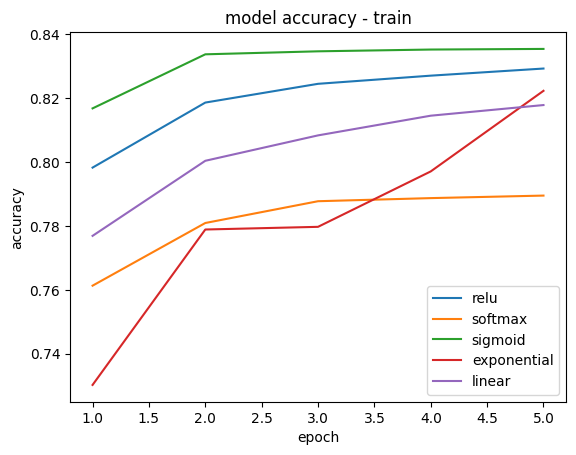

In [321]:
for i in range(5):
    plt.plot(range(1,6), train_acc_f[i,:], label=activ_func_list[i])
plt.title('model accuracy - train')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

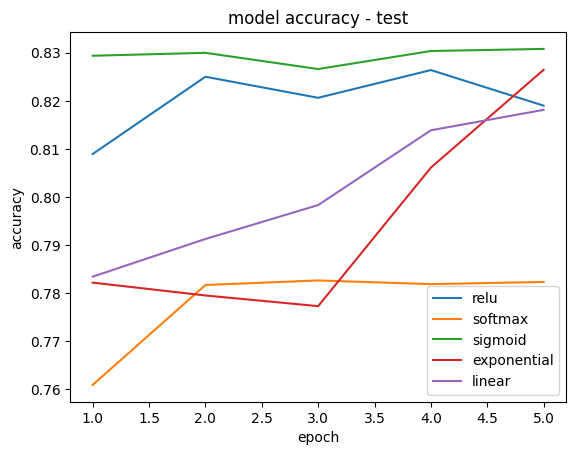

In [322]:
for i in range(5):
    plt.plot(range(1,6), test_acc_f[i,:], label=activ_func_list[i])
plt.title('model accuracy - test')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

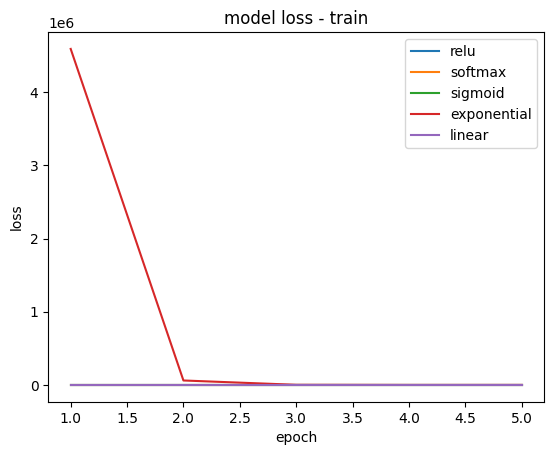

In [323]:
for i in range(5):
    plt.plot(range(1,6), train_loss_f[i,:], label=activ_func_list[i])
plt.title('model loss - train')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

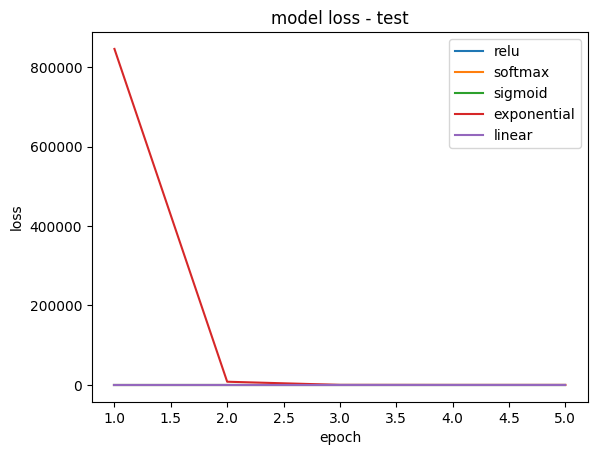

In [324]:
for i in range(5):
    plt.plot(range(1,6), test_loss_f[i,:], label=activ_func_list[i])
plt.title('model loss - test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

Exponential clearly dominated the loss plots. It turned out that the value was higher then all the others at all times.

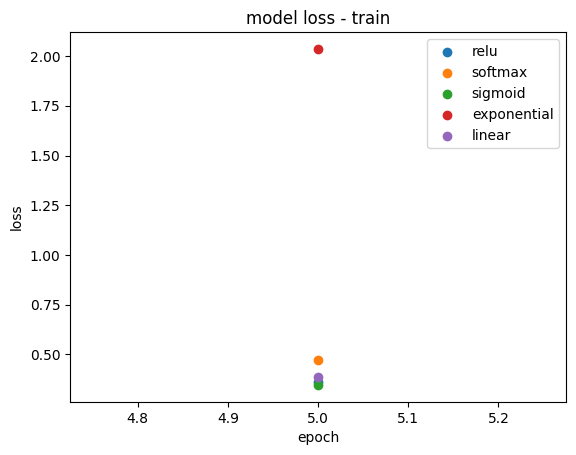

In [325]:
for i in range(5):
    plt.scatter(range(5,6), train_loss_f[i,4:], label=activ_func_list[i])
plt.title('model loss - train')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

So it was plotted without the exponential activation function

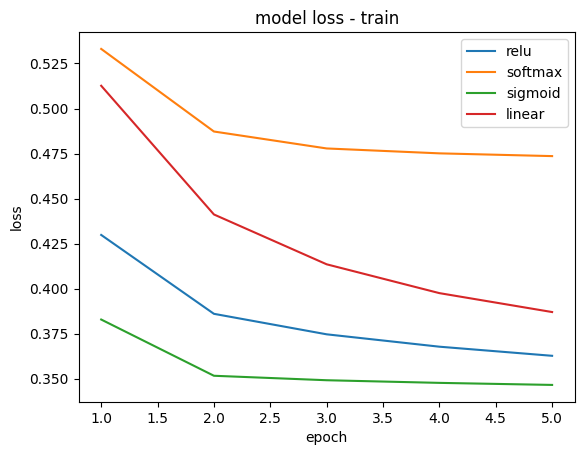

In [327]:
for i in [0,1,2,4]:
    plt.plot(range(1,6), train_loss_f[i,:], label=activ_func_list[i])
plt.title('model loss - train')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

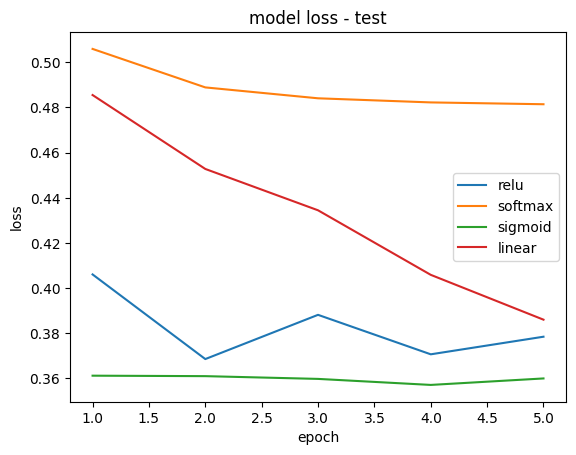

In [326]:
for i in [0,1,2,4]:
    plt.plot(range(1,6), test_loss_f[i,:], label=activ_func_list[i])
plt.title('model loss - test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

Clearly the best one for both loss and accuracy is sigmoid function. Soft max seemms to be the worst of analysed fuctions (except for the exponential).

# Test optimizers

In [281]:
def get_model_optimizer(optimizer_name: str):
    model_optimizer = models.Sequential()
    model_optimizer.add(Input(shape=(40,)))
    model_optimizer.add(layers.Dense(128, activation='relu'))
    model_optimizer.add(layers.Dense(2, activation='softmax'))
    model_optimizer.compile(optimizer=optimizer_name,
    loss='categorical_crossentropy',
    metrics=['accuracy'])
    return model_optimizer

In [290]:
m=10
en=5
train_acc_o = np.zeros((6,en))
test_acc_o = np.zeros((6,en))
train_loss_o = np.zeros((6,en))
test_loss_o = np.zeros((6,en))
k=0

activ_optimizer = ['sgd', 'rmsprop', 'adam', 'adagrad', 'adamax', 'lion']
for i in activ_optimizer:
    ttrain_acc_o = np.zeros((en,m))
    ttest_acc_o = np.zeros((en,m))
    ttrain_loss_o = np.zeros((en,m))
    ttest_loss_o = np.zeros((en,m))
    for j in range(m):
        temp_model1 = get_model_optimizer(i)
        temp_model = temp_model1.fit(x_train, y_train, epochs=en, validation_data=(x_test, y_test))
        ttrain_acc_o[:,j] = temp_model.history['accuracy']
        ttest_acc_o[:,j] = temp_model.history['val_accuracy']
        ttrain_loss_o[:,j] = temp_model.history['loss']
        ttest_loss_o[:,j] = temp_model.history['val_loss']
    train_acc_o[k,:] = ttrain_acc_o.mean(axis=1)
    test_acc_o[k,:] = ttest_acc_o.mean(axis=1)
    train_loss_o[k,:] = ttrain_loss_o.mean(axis=1)
    test_loss_o[k,:] = ttest_loss_o.mean(axis=1)
    k += 1

Epoch 1/5
 111/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6858 - loss: 2.3607

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7528 - loss: 0.8170 - val_accuracy: 0.7904 - val_loss: 0.4653
Epoch 2/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7760 - loss: 0.4723 - val_accuracy: 0.7807 - val_loss: 0.4446
Epoch 3/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7866 - loss: 0.4510 - val_accuracy: 0.7749 - val_loss: 0.4383
Epoch 4/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7875 - loss: 0.4352 - val_accuracy: 0.7827 - val_loss: 0.4423
Epoch 5/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7936 - loss: 0.4188 - val_accuracy: 0.7869 - val_loss: 0.4439
Epoch 1/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7464 - loss: 0.8663 - val_accuracy: 0.5701 - val_loss: 0.6722
Epoch 2/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7744 - loss: 0.4753 - val_accuracy: 0.7561 - val_loss: 0.5382
Epoch 3/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7781 - loss: 0.4529 - val_accuracy: 0.79

In [302]:
# np.save('oopt_train_acc', train_acc_o)
# np.save('oopt_train_loss', train_loss_o)
# np.save('oopt_test_acc', test_acc_o)
# np.save('oopt_test_loss', test_loss_o)

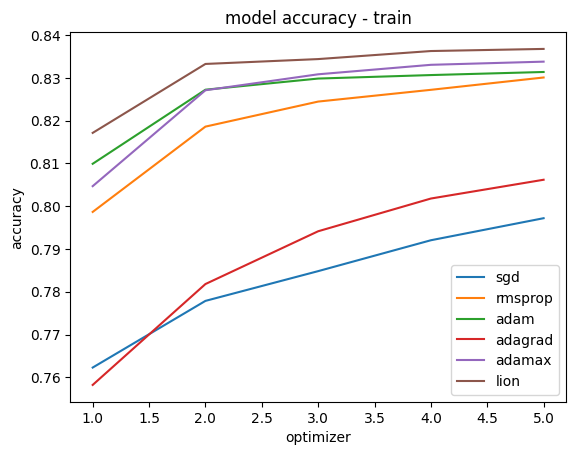

In [297]:
for i in range(6):
    plt.plot(range(1,6), train_acc_o[i,:], label=activ_optimizer[i])
plt.title('model accuracy - train')
plt.ylabel('accuracy')
plt.xlabel('optimizer')
plt.legend()
plt.show()

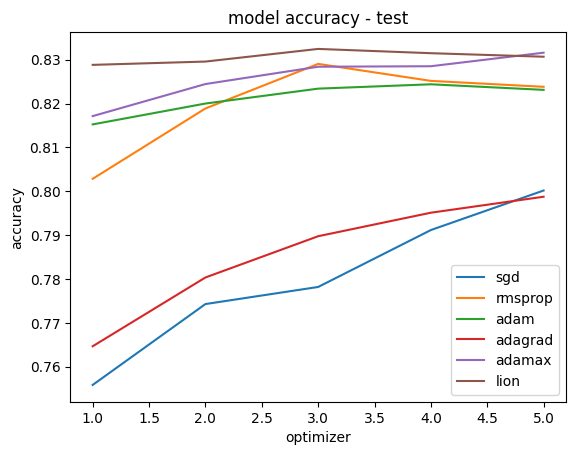

In [299]:
for i in range(6):
    plt.plot(range(1,6), test_acc_o[i,:], label=activ_optimizer[i])
plt.title('model accuracy - test')
plt.ylabel('accuracy')
plt.xlabel('optimizer')
plt.legend()
plt.show()

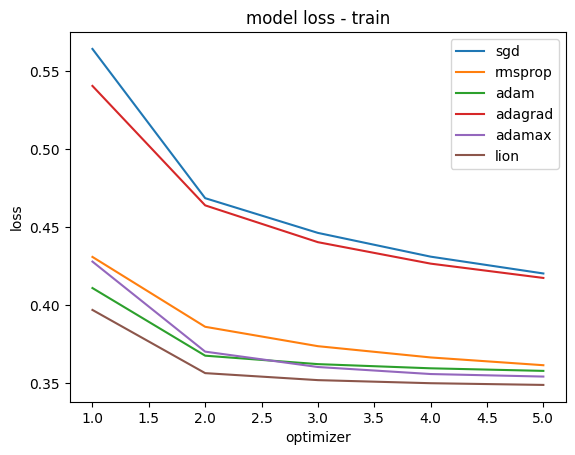

In [300]:
for i in range(6):
    plt.plot(range(1,6), train_loss_o[i,:], label=activ_optimizer[i])
plt.title('model loss - train')
plt.ylabel('loss')
plt.xlabel('optimizer')
plt.legend()
plt.show()

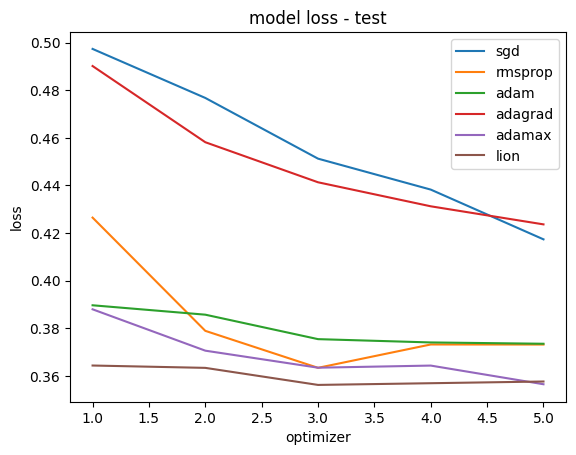

In [301]:
for i in range(6):
    plt.plot(range(1,6), test_loss_o[i,:], label=activ_optimizer[i])
plt.title('model loss - test')
plt.ylabel('loss')
plt.xlabel('optimizer')
plt.legend()
plt.show()

Based on these result we obtain groups of functions:
 - work well:
    - 'rmsprop',
    - 'adam',
    - 'adamax',
    - 'lion'
 - work poorly:
    - 'sgd',
    - 'adagrad'.
    
With these groups separated the best optimizer was chosen (it's subjectively the best) as lion.

# Test number of neurons

In [56]:
def get_model_neurons(n_neurons: int):
    model_optimizer = models.Sequential()
    model_optimizer.add(Input(shape=(40,)))
    model_optimizer.add(layers.Dense(n_neurons, activation='relu'))
    model_optimizer.add(layers.Dense(2, activation='softmax'))
    model_optimizer.compile(optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
    return model_optimizer

In [57]:
n=10
m=20
train_acc_n = np.zeros((n,m))
test_acc_n = np.zeros((n,m))
train_loss_n = np.zeros((n,m))
test_loss_n = np.zeros((n,m))
k=0
for i in range(n):
    for j in range(m):
        temp_model1 = get_model_neurons(2**(i+1))
        temp_model = temp_model1.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
        train_acc_n[k,j] = temp_model.history['accuracy'][-1]
        test_acc_n[k,j] = temp_model.history['val_accuracy'][-1]
        train_loss_n[k,j] = temp_model.history['loss'][-1]
        test_loss_n[k,j] = temp_model.history['val_loss'][-1]
    k += 1

Epoch 1/5


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7566 - loss: 0.5918 - val_accuracy: 0.7561 - val_loss: 0.4579
Epoch 2/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7613 - loss: 0.4341 - val_accuracy: 0.8016 - val_loss: 0.4144
Epoch 3/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8112 - loss: 0.3992 - val_accuracy: 0.8163 - val_loss: 0.3955
Epoch 4/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8215 - loss: 0.3856 - val_accuracy: 0.8205 - val_loss: 0.3851
Epoch 5/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8230 - loss: 0.3766 - val_accuracy: 0.8249 - val_loss: 0.3816
Epoch 1/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7638 - loss: 0.5184 - val_accuracy: 0.7996 - val_loss: 0.4142
Epoch 2/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8126 - loss: 0.3960 - val_accuracy: 0.8191 - val_loss: 0.3862
Epoch 3/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8249 - loss: 0.3704 - val_accuracy: 0.81

In [58]:
# np.save('n_train_acc', train_acc_n)
# np.save('n_train_loss', train_loss_n)
# np.save('n_test_acc', test_acc_n)
# np.save('n_test_loss', test_loss_n)

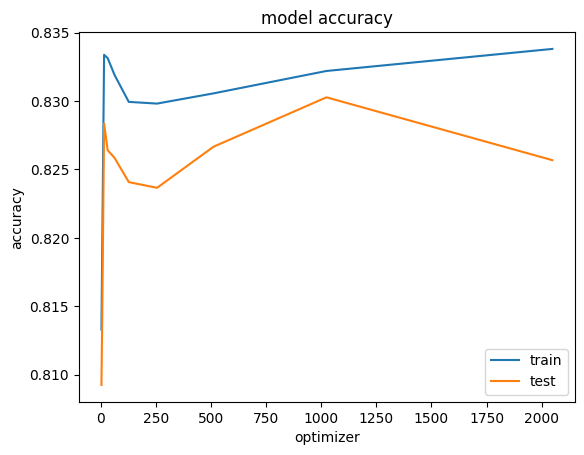

In [63]:
plt.plot([2**(i+1) for i in range(1,n+1)], train_acc_n.mean(axis=1))
plt.plot([2**(i+1) for i in range(1,n+1)], test_acc_n.mean(axis=1))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('number of neurons')
plt.legend(['train', 'test'])
plt.show()

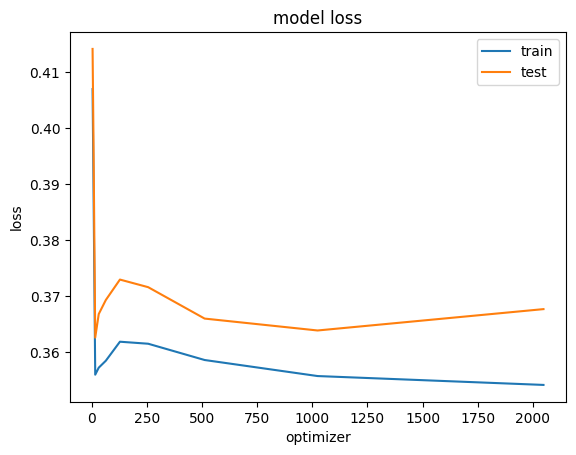

In [62]:
plt.plot([2**(i+1) for i in range(1,n+1)], train_loss_n.mean(axis=1))
plt.plot([2**(i+1) for i in range(1,n+1)], test_loss_n.mean(axis=1))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('optimizer')
plt.legend(['train', 'test'])
plt.show()

Clearly, for really small numbers of neurons, model is not working too well. Then visible increase in accuracy can be noted. However, there forms a suspicion that for large numbers of neurons model might be overfitting. Thus the optimal number of neurons for this case would be around $2^{10} = 1024$ (if not even a bit less).

# Comparison of the best models in each category

## Optimal epoch number

In [328]:
model_e = models.Sequential()
model_e.add(Input(shape=(40,)))
model_e.add(layers.Dense(128, activation='relu'))
model_e.add(layers.Dense(2, activation='softmax'))
model_e.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy', 'precision'])

In [329]:
model_e1 = model_e.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7725 - loss: 0.5209 - precision: 0.7725 - val_accuracy: 0.8274 - val_loss: 0.3655 - val_precision: 0.8274
Epoch 2/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8164 - loss: 0.3903 - precision: 0.8164 - val_accuracy: 0.8159 - val_loss: 0.3796 - val_precision: 0.8159
Epoch 3/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8249 - loss: 0.3780 - precision: 0.8249 - val_accuracy: 0.8299 - val_loss: 0.3693 - val_precision: 0.8299
Epoch 4/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8211 - loss: 0.3712 - precision: 0.8211 - val_accuracy: 0.8329 - val_loss: 0.3583 - val_precision: 0.8329
Epoch 5/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8312 - loss: 0.3602 - precision: 0.8312 - val_accuracy: 0.8263 - val_loss: 0.3774 - val_precision: 0.8263
Epoch 6/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8333 - loss: 0.3527 - precision: 0.8333 - val_accuracy: 0.8135 - val_loss

## Best activation function

In [330]:
model_activ = models.Sequential()
model_activ.add(Input(shape=(40,)))
model_activ.add(layers.Dense(128, activation='sigmoid'))
model_activ.add(layers.Dense(2, activation='softmax'))
model_activ.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy', 'precision'])

In [331]:
model_activ1 = model_activ.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7995 - loss: 0.4191 - precision: 0.7995 - val_accuracy: 0.8300 - val_loss: 0.3631 - val_precision: 0.8300
Epoch 2/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8348 - loss: 0.3500 - precision: 0.8348 - val_accuracy: 0.8327 - val_loss: 0.3529 - val_precision: 0.8327
Epoch 3/5
 584/1145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8314 - loss: 0.3499 - precision: 0.8314

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8326 - loss: 0.3490 - precision: 0.8326 - val_accuracy: 0.8265 - val_loss: 0.3588 - val_precision: 0.8265
Epoch 4/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8377 - loss: 0.3456 - precision: 0.8377 - val_accuracy: 0.8326 - val_loss: 0.3513 - val_precision: 0.8326
Epoch 5/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8408 - loss: 0.3441 - precision: 0.8408 - val_accuracy: 0.8291 - val_loss: 0.3568 - val_precision: 0.8291


## Best optimizer

In [332]:
model_o = models.Sequential()
model_o.add(Input(shape=(40,)))
model_o.add(layers.Dense(128, activation='relu'))
model_o.add(layers.Dense(2, activation='softmax'))
model_o.compile(optimizer='lion',
loss='categorical_crossentropy',
metrics=['accuracy', 'precision'])

In [333]:
model_o1 = model_o.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
 664/1145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7768 - loss: 0.4738 - precision: 0.7768

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7919 - loss: 0.4426 - precision: 0.7919 - val_accuracy: 0.8249 - val_loss: 0.3779 - val_precision: 0.8249
Epoch 2/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8318 - loss: 0.3559 - precision: 0.8318 - val_accuracy: 0.8217 - val_loss: 0.3656 - val_precision: 0.8217
Epoch 3/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8323 - loss: 0.3559 - precision: 0.8323 - val_accuracy: 0.8219 - val_loss: 0.3710 - val_precision: 0.8219
Epoch 4/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8357 - loss: 0.3479 - precision: 0.8357 - val_accuracy: 0.8324 - val_loss: 0.3605 - val_precision: 0.8324
Epoch 5/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8344 - loss: 0.3517 - precision: 0.8344 - val_accuracy: 0.8328 - val_loss: 0.3593 - val_precision: 0.8328


## Best neuron number

In [334]:
model_n = models.Sequential()
model_n.add(Input(shape=(40,)))
model_n.add(layers.Dense(2**10, activation='relu'))
model_n.add(layers.Dense(2, activation='softmax'))
model_n.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy', 'precision'])

In [335]:
model_n1 = model_n.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
 533/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7383 - loss: 0.7488 - precision: 0.7383

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7588 - loss: 0.6333 - precision: 0.7588 - val_accuracy: 0.8232 - val_loss: 0.3868 - val_precision: 0.8232
Epoch 2/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8155 - loss: 0.3830 - precision: 0.8155 - val_accuracy: 0.8136 - val_loss: 0.4022 - val_precision: 0.8136
Epoch 3/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8251 - loss: 0.3666 - precision: 0.8251 - val_accuracy: 0.8291 - val_loss: 0.3597 - val_precision: 0.8291
Epoch 4/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8285 - loss: 0.3633 - precision: 0.8285 - val_accuracy: 0.8287 - val_loss: 0.3606 - val_precision: 0.8287
Epoch 5/5
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8336 - loss: 0.3545 - precision: 0.8336 - val_accuracy: 0.8298 - val_loss: 0.3562 - val_precision: 0.8298


## Combo

Combines all the best attributes. 

<b>Warning:</b> it doesn't mean this model is the best one. It combines parameters that proved to worked well separately appllied to the base model.

In [336]:
model_all = models.Sequential()
model_all.add(Input(shape=(40,)))
model_all.add(layers.Dense(2**10, activation='sigmoid'))
model_all.add(layers.Dense(2, activation='softmax'))
model_all.compile(optimizer='lion',
loss='categorical_crossentropy',
metrics=['accuracy', 'precision'])

In [337]:
model_all1 = model_all.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
 520/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7980 - loss: 0.4297 - precision: 0.7980

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8083 - loss: 0.4042 - precision: 0.8083 - val_accuracy: 0.8237 - val_loss: 0.3636 - val_precision: 0.8237
Epoch 2/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8223 - loss: 0.3660 - precision: 0.8223 - val_accuracy: 0.8293 - val_loss: 0.3970 - val_precision: 0.8293
Epoch 3/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8297 - loss: 0.3610 - precision: 0.8297 - val_accuracy: 0.8313 - val_loss: 0.3582 - val_precision: 0.8313
Epoch 4/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8308 - loss: 0.3547 - precision: 0.8308 - val_accuracy: 0.8349 - val_loss: 0.3549 - val_precision: 0.8349
Epoch 5/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8306 - loss: 0.3561 - precision: 0.8306 - val_accuracy: 0.7970 - val_loss: 0.4199 - val_precision: 0.7970
Epoch 6/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8277 - loss: 0.3619 - precision: 0.8277 - val_accuracy: 0.8360 - val_loss

## Comparison

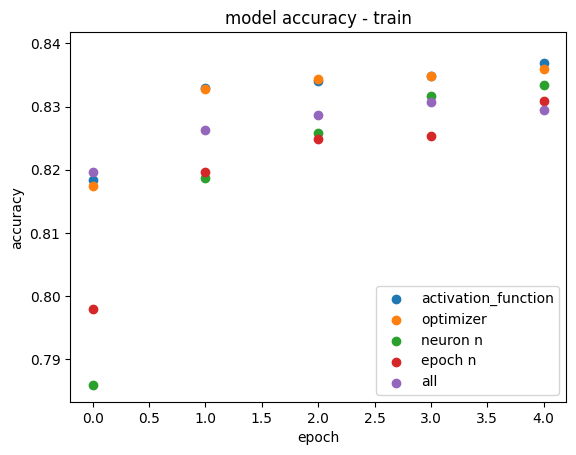

In [343]:
plt.scatter(range(5), model_activ1.history['accuracy'], label='activation_function')
plt.scatter(range(5), model_o1.history['accuracy'], label='optimizer')
plt.scatter(range(5), model_n1.history['accuracy'], label='neuron n')
plt.scatter(range(20), model_e1.history['accuracy'], label='epoch n')
plt.scatter(range(20), model_all1.history['accuracy'], label='all')
plt.legend()
plt.title('model accuracy - train')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim([-0.2,4.2])
plt.show()

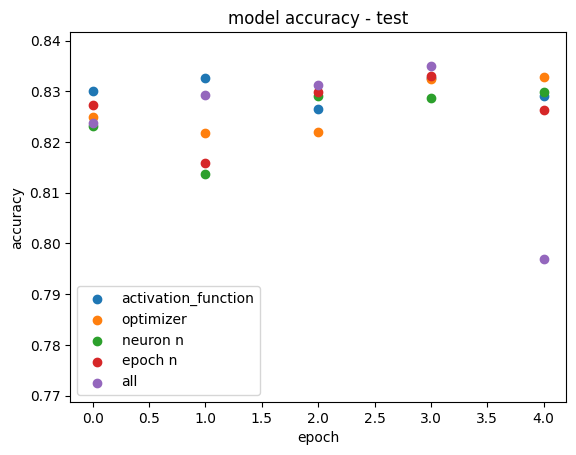

In [344]:
plt.scatter(range(5), model_activ1.history['val_accuracy'], label='activation_function')
plt.scatter(range(5), model_o1.history['val_accuracy'], label='optimizer')
plt.scatter(range(5), model_n1.history['val_accuracy'], label='neuron n')
plt.scatter(range(20), model_e1.history['val_accuracy'], label='epoch n')
plt.scatter(range(20), model_all1.history['val_accuracy'], label='all')
plt.legend()
plt.title('model accuracy - test')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim([-0.2,4.2])
plt.show()

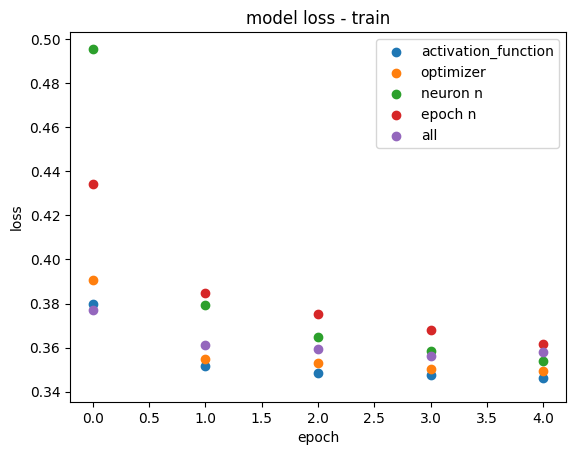

In [345]:
plt.scatter(range(5), model_activ1.history['loss'], label='activation_function')
plt.scatter(range(5), model_o1.history['loss'], label='optimizer')
plt.scatter(range(5), model_n1.history['loss'], label='neuron n')
plt.scatter(range(20), model_e1.history['loss'], label='epoch n')
plt.scatter(range(20), model_all1.history['loss'], label='all')
plt.title('model loss - train')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim([-0.2,4.2])
plt.legend()
plt.show()

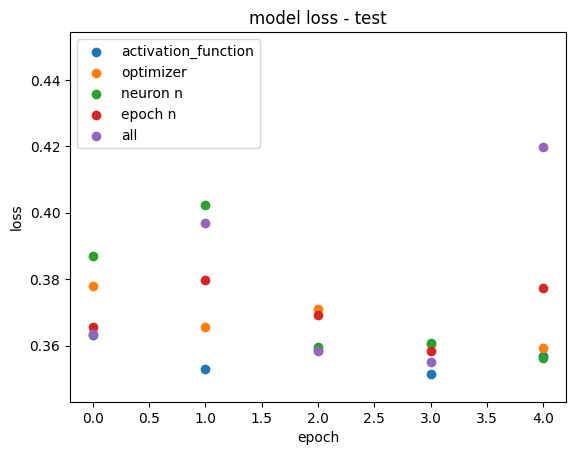

In [346]:
plt.scatter(range(5), model_activ1.history['val_loss'], label='activation_function')
plt.scatter(range(5), model_o1.history['val_loss'], label='optimizer')
plt.scatter(range(5), model_n1.history['val_loss'], label='neuron n')
plt.scatter(range(20), model_e1.history['val_loss'], label='epoch n')
plt.scatter(range(20), model_all1.history['val_loss'], label='all')
plt.title('model loss - test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim([-0.2,4.2])
plt.legend()
plt.show()

Based on the plots the following conclusions can be formed:
 - Even, though the course of learing for different models is visibly different, the end values (here taken as epoch 5, so it's not really a great idea to compare results from number of epochs this way) of accuracy and loss are pretty similar.
 - As expected model fits better to the train data and small differences in performance can be denoted with respect to the test set.

## Confusion matrix on train set

### Activation function

 505/1145 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

         0.0       0.64      0.69      0.67      8709
         1.0       0.90      0.88      0.89     27922

    accuracy                           0.84     36631
   macro avg       0.77      0.78      0.78     36631
weighted avg       0.84      0.84      0.84     36631



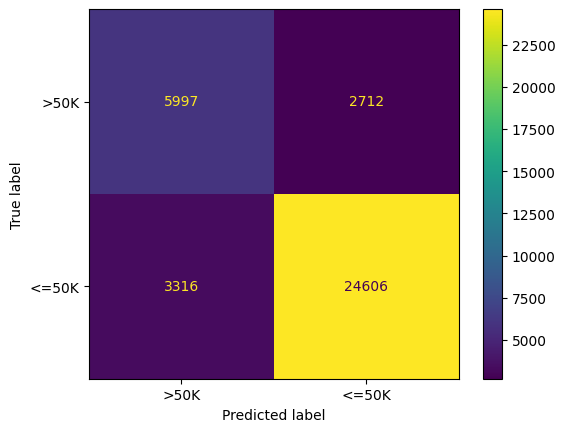

In [347]:
y_pred = model_activ.predict(x_train)
y_pred_r = y_pred.round()
print(classification_report(y_train[:,0], y_pred_r[:,0]))
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train[:,0], y_pred_r[:,0]), display_labels = ['>50K', '<=50K']).plot()

### Optimizer

 684/1145 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

         0.0       0.73      0.48      0.58      8709
         1.0       0.85      0.95      0.90     27922

    accuracy                           0.83     36631
   macro avg       0.79      0.71      0.74     36631
weighted avg       0.82      0.83      0.82     36631



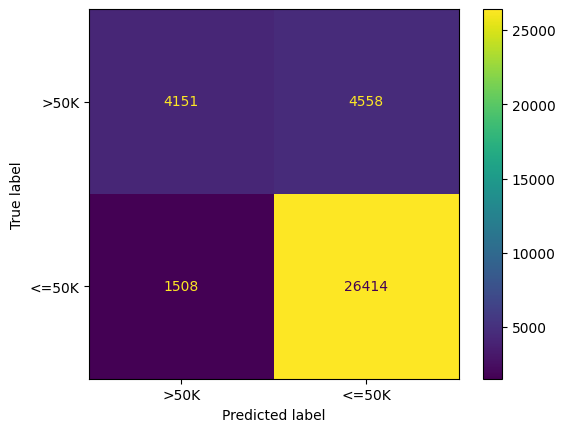

In [348]:
y_pred = model_o.predict(x_train)
y_pred_r = y_pred.round()
print(classification_report(y_train[:,0], y_pred_r[:,0]))
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train[:,0], y_pred_r[:,0]), display_labels = ['>50K', '<=50K']).plot()

### Number of neurons

 790/1145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

         0.0       0.68      0.60      0.64      8709
         1.0       0.88      0.91      0.90     27922

    accuracy                           0.84     36631
   macro avg       0.78      0.76      0.77     36631
weighted avg       0.83      0.84      0.83     36631



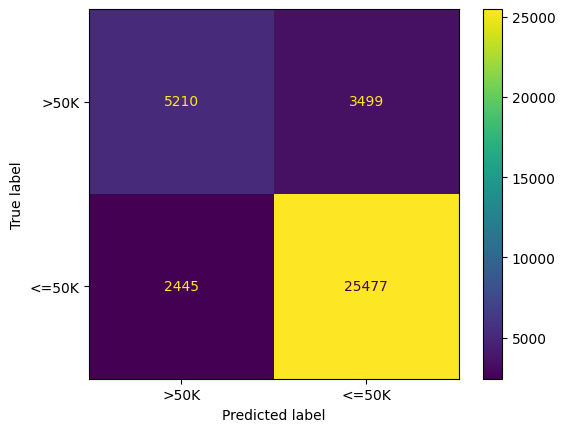

In [349]:
y_pred = model_n.predict(x_train)
y_pred_r = y_pred.round()
print(classification_report(y_train[:,0], y_pred_r[:,0]))
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train[:,0], y_pred_r[:,0]), display_labels = ['>50K', '<=50K']).plot()

### Number of epochs

 702/1145 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66      8709
         1.0       0.89      0.89      0.89     27922

    accuracy                           0.84     36631
   macro avg       0.77      0.78      0.78     36631
weighted avg       0.84      0.84      0.84     36631



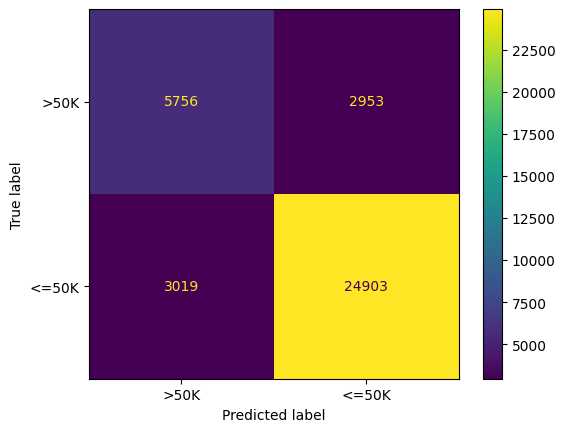

In [350]:
y_pred = model_e.predict(x_train)
y_pred_r = y_pred.round()
print(classification_report(y_train[:,0], y_pred_r[:,0]))
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train[:,0], y_pred_r[:,0]), display_labels = ['>50K', '<=50K']).plot()

### Combo

 647/1145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

         0.0       0.63      0.72      0.67      8709
         1.0       0.91      0.87      0.89     27922

    accuracy                           0.83     36631
   macro avg       0.77      0.79      0.78     36631
weighted avg       0.84      0.83      0.84     36631



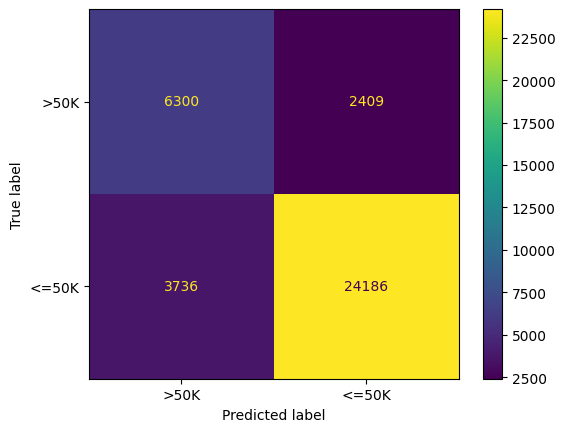

In [351]:
y_pred = model_all.predict(x_train)
y_pred_r = y_pred.round()
print(classification_report(y_train[:,0], y_pred_r[:,0]))
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train[:,0], y_pred_r[:,0]), display_labels = ['>50K', '<=50K']).plot()

On the train set:
 - 'optimizer' recognized correctly the most labels $<=50$ K - $26414$
 - 'combo' recognized correctly the most labels $>50$ K - $6300$
 - 'number of neurons' recognized correctly the most labels - $30687$

## Confusion matrix on test set

### Activation function

382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

         0.0       0.64      0.68      0.66      2978
         1.0       0.89      0.88      0.89      9233

    accuracy                           0.83     12211
   macro avg       0.77      0.78      0.77     12211
weighted avg       0.83      0.83      0.83     12211



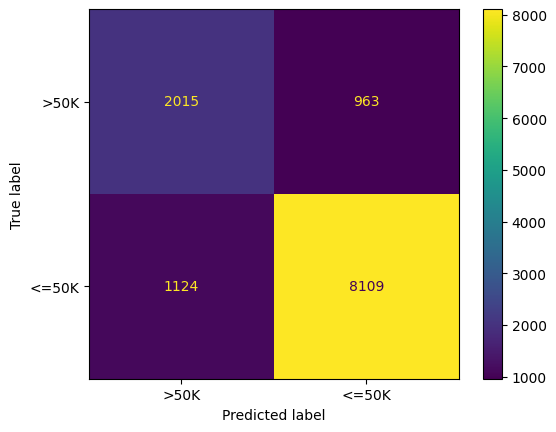

In [352]:
y_pred = model_activ.predict(x_test)
y_pred_r = y_pred.round()
print(classification_report(y_test[:,0], y_pred_r[:,0]))
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test[:,0], y_pred_r[:,0]), display_labels = ['>50K', '<=50K']).plot()

### Optimizer

382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

         0.0       0.75      0.47      0.58      2978
         1.0       0.85      0.95      0.90      9233

    accuracy                           0.83     12211
   macro avg       0.80      0.71      0.74     12211
weighted avg       0.82      0.83      0.82     12211



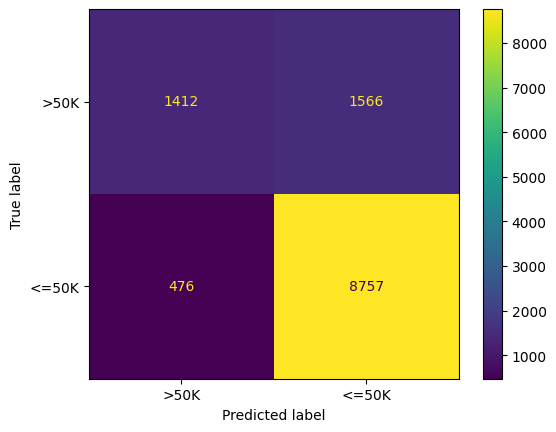

In [353]:
y_pred = model_o.predict(x_test)
y_pred_r = y_pred.round()
print(classification_report(y_test[:,0], y_pred_r[:,0]))
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test[:,0], y_pred_r[:,0]), display_labels = ['>50K', '<=50K']).plot()

### Number of neurons

382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

         0.0       0.67      0.59      0.63      2978
         1.0       0.87      0.91      0.89      9233

    accuracy                           0.83     12211
   macro avg       0.77      0.75      0.76     12211
weighted avg       0.82      0.83      0.83     12211



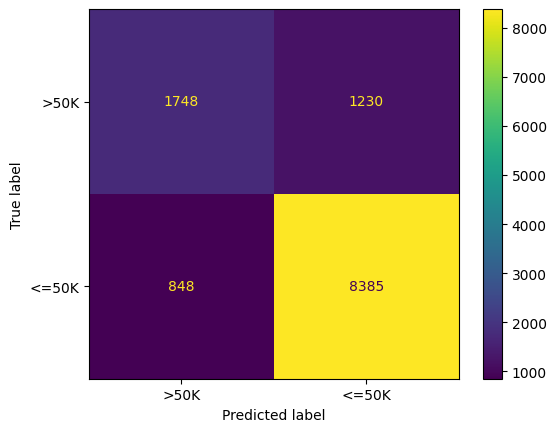

In [354]:
y_pred = model_n.predict(x_test)
y_pred_r = y_pred.round()
print(classification_report(y_test[:,0], y_pred_r[:,0]))
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test[:,0], y_pred_r[:,0]), display_labels = ['>50K', '<=50K']).plot()

### Number of epochs

382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

         0.0       0.65      0.65      0.65      2978
         1.0       0.89      0.89      0.89      9233

    accuracy                           0.83     12211
   macro avg       0.77      0.77      0.77     12211
weighted avg       0.83      0.83      0.83     12211



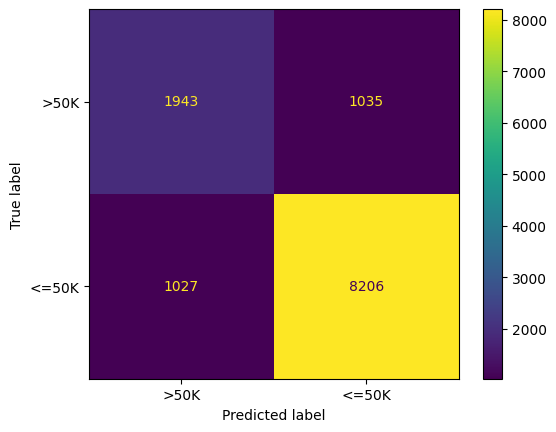

In [355]:
y_pred = model_e.predict(x_test)
y_pred_r = y_pred.round()
print(classification_report(y_test[:,0], y_pred_r[:,0]))
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test[:,0], y_pred_r[:,0]), display_labels = ['>50K', '<=50K']).plot()

### Combo

382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

         0.0       0.62      0.70      0.66      2978
         1.0       0.90      0.86      0.88      9233

    accuracy                           0.82     12211
   macro avg       0.76      0.78      0.77     12211
weighted avg       0.83      0.82      0.82     12211



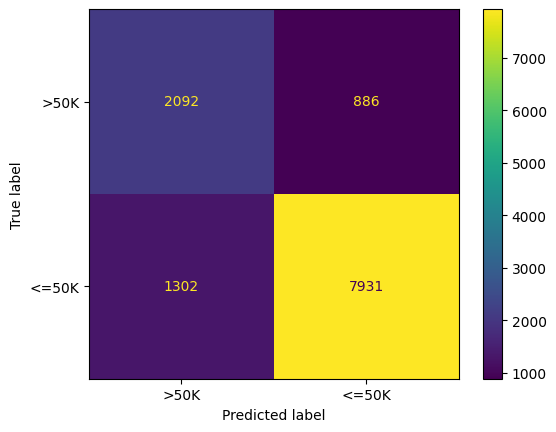

In [356]:
y_pred = model_all.predict(x_test)
y_pred_r = y_pred.round()
print(classification_report(y_test[:,0], y_pred_r[:,0]))
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test[:,0], y_pred_r[:,0]), display_labels = ['>50K', '<=50K']).plot()

On the test set:
 - 'optimizer' recognized correctly the most labels $<=50$ K - $8757$
 - 'combo' recognized correctly the most labels $>50$ K - $2092$
 - 'optimizer recognized correctly the most labels - $10169$

The results are consistent with the ones recieved for train test

## Short additional test with data normalization

In [250]:
base_data2 = adult_data2[['age', 'hours-per-week', 'education-num']]
base_data2 = base_data2 - (base_data2.mean())/base_data2.std()
split_sex = pd.get_dummies(adult_data2['sex'])
base_data2.loc[:, split_sex.columns] = split_sex
split_occupation = pd.get_dummies(adult_data2['occupation'])
base_data2.loc[:, split_occupation.columns] = split_occupation
split_workclass = pd.get_dummies(adult_data2['workclass'])
base_data2.loc[:, split_workclass.columns] = split_workclass
split_marital = pd.get_dummies(adult_data2['marital-status'])
base_data2.loc[:, split_marital.columns] = split_marital
split_relationship = pd.get_dummies(adult_data2['relationship'])
base_data2.loc[:, split_relationship.columns] = split_relationship
target_data2 = adult_data2['targets']
np.random.seed(1234)
x_train2, x_test2, y_train2, y_test2 = train_test_split(base_data2*1, target_data2*1)

In [251]:
x_train2 = np.asarray(x_train2).reshape((36631, 40)).astype('float32')
x_test2 = np.array(x_test2).reshape((12211, 40)).astype('float32')

In [252]:
y_train2 = np.asarray(pd.get_dummies(y_train2)).astype(float)
y_test2 = np.asarray(pd.get_dummies(y_test2)).astype(float)

In [253]:
model = models.Sequential()
model.add(Input(shape=(40,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [254]:
model_adult = model.fit(x_train2, y_train2, epochs=100, validation_data=(x_test2, y_test2))

Epoch 1/100


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7866 - loss: 0.4895 - val_accuracy: 0.8057 - val_loss: 0.4563
Epoch 2/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8188 - loss: 0.3876 - val_accuracy: 0.8319 - val_loss: 0.3593
Epoch 3/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8281 - loss: 0.3671 - val_accuracy: 0.8335 - val_loss: 0.3619
Epoch 4/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8292 - loss: 0.3636 - val_accuracy: 0.8273 - val_loss: 0.3600
Epoch 5/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8326 - loss: 0.3578 - val_accuracy: 0.8141 - val_loss: 0.4191
Epoch 6/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8321 - loss: 0.3578 - val_accuracy: 0.8292 - val_loss: 0.3570
Epoch 7/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8300 - loss: 0.3552 - val_accuracy: 0.8262 - val_loss: 0.3575
Epoch 8/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8333 - loss: 0.3558 - val_

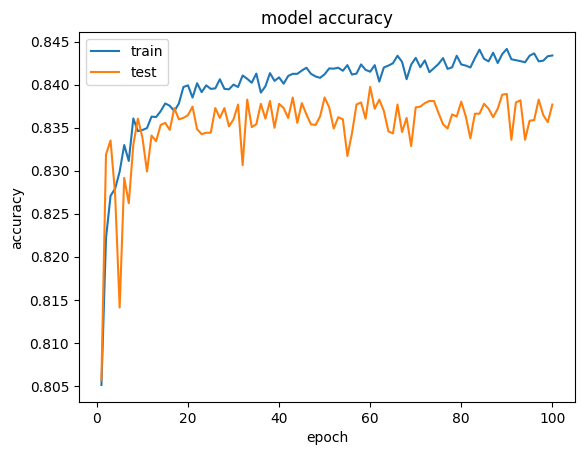

In [255]:
plt.plot(range(1,101),model_adult.history['accuracy'])
plt.plot(range(1,101), model_adult.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

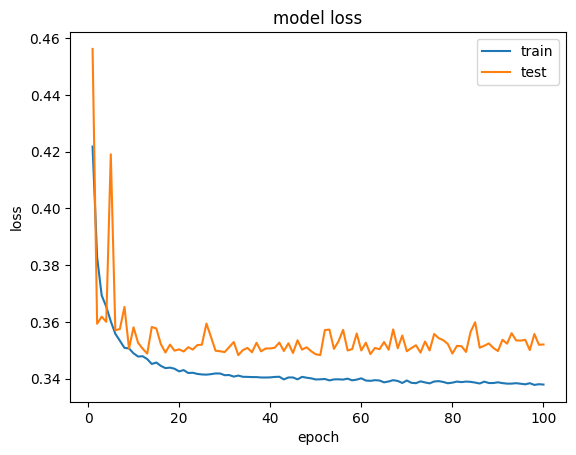

In [256]:
plt.plot(range(1,101), model_adult.history['loss'])
plt.plot(range(1,101), model_adult.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

Change isn't that drastic in terms of improving performace.

# Regression task

In [2]:
mpg_data = fetch_ucirepo(id=9)

In [3]:
mpg_data.variables

name     role         type demographic description units  \
0  displacement  Feature   Continuous        None        None  None   
1           mpg   Target   Continuous        None        None  None   
2     cylinders  Feature      Integer        None        None  None   
3    horsepower  Feature   Continuous        None        None  None   
4        weight  Feature   Continuous        None        None  None   
5  acceleration  Feature   Continuous        None        None  None   
6    model_year  Feature      Integer        None        None  None   
7        origin  Feature      Integer        None        None  None   
8      car_name       ID  Categorical        None        None  None   

  missing_values  
0             no  
1             no  
2             no  
3            yes  
4             no  
5             no  
6             no  
7             no  
8             no

# EDA

In [4]:
mpg_data.data.features

displacement  cylinders  horsepower  weight  acceleration  model_year  \
0           307.0          8       130.0    3504          12.0          70   
1           350.0          8       165.0    3693          11.5          70   
2           318.0          8       150.0    3436          11.0          70   
3           304.0          8       150.0    3433          12.0          70   
4           302.0          8       140.0    3449          10.5          70   
..            ...        ...         ...     ...           ...         ...   
393         140.0          4        86.0    2790          15.6          82   
394          97.0          4        52.0    2130          24.6          82   
395         135.0          4        84.0    2295          11.6          82   
396         120.0          4        79.0    2625          18.6          82   
397         119.0          4        82.0    2720          19.4          82   

     origin  
0         1  
1         1  
2         1  
3         1  
4         1  
..      ...  
393       1  
394       2  
395       1  
396       1  
397       1  

[398 rows x 7 columns]

In [5]:
mpg_data2 = mpg_data.data.features.copy()
mpg_data2.loc[:, 'targets'] = mpg_data.data.targets.copy()

In [6]:
mpg_data2

displacement  cylinders  horsepower  weight  acceleration  model_year  \
0           307.0          8       130.0    3504          12.0          70   
1           350.0          8       165.0    3693          11.5          70   
2           318.0          8       150.0    3436          11.0          70   
3           304.0          8       150.0    3433          12.0          70   
4           302.0          8       140.0    3449          10.5          70   
..            ...        ...         ...     ...           ...         ...   
393         140.0          4        86.0    2790          15.6          82   
394          97.0          4        52.0    2130          24.6          82   
395         135.0          4        84.0    2295          11.6          82   
396         120.0          4        79.0    2625          18.6          82   
397         119.0          4        82.0    2720          19.4          82   

     origin  targets  
0         1     18.0  
1         1     15.0  
2         1     18.0  
3         1     16.0  
4         1     17.0  
..      ...      ...  
393       1     27.0  
394       2     44.0  
395       1     32.0  
396       1     28.0  
397       1     31.0  

[398 rows x 8 columns]

## Check values

## Null handling

In [7]:
mpg_data2.shape

(398, 8)

In [8]:
mpg_data2.isnull().sum()

displacement    0
cylinders       0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
targets         0
dtype: int64

In [9]:
mpg_data2.loc[mpg_data2['horsepower'].isnull(),'horsepower'] = mpg_data2['horsepower'].median()

In [10]:
mpg_data2.describe()

displacement   cylinders  horsepower       weight  acceleration  \
count    398.000000  398.000000  398.000000   398.000000    398.000000   
mean     193.425879    5.454774  104.304020  2970.424623     15.568090   
std      104.269838    1.701004   38.222625   846.841774      2.757689   
min       68.000000    3.000000   46.000000  1613.000000      8.000000   
25%      104.250000    4.000000   76.000000  2223.750000     13.825000   
50%      148.500000    4.000000   93.500000  2803.500000     15.500000   
75%      262.000000    8.000000  125.000000  3608.000000     17.175000   
max      455.000000    8.000000  230.000000  5140.000000     24.800000   

       model_year      origin     targets  
count  398.000000  398.000000  398.000000  
mean    76.010050    1.572864   23.514573  
std      3.697627    0.802055    7.815984  
min     70.000000    1.000000    9.000000  
25%     73.000000    1.000000   17.500000  
50%     76.000000    1.000000   23.000000  
75%     79.000000    2.000000   29.000000  
max     82.000000    3.000000   46.600000

## Numerical data

In [11]:
mpg_data2

displacement  cylinders  horsepower  weight  acceleration  model_year  \
0           307.0          8       130.0    3504          12.0          70   
1           350.0          8       165.0    3693          11.5          70   
2           318.0          8       150.0    3436          11.0          70   
3           304.0          8       150.0    3433          12.0          70   
4           302.0          8       140.0    3449          10.5          70   
..            ...        ...         ...     ...           ...         ...   
393         140.0          4        86.0    2790          15.6          82   
394          97.0          4        52.0    2130          24.6          82   
395         135.0          4        84.0    2295          11.6          82   
396         120.0          4        79.0    2625          18.6          82   
397         119.0          4        82.0    2720          19.4          82   

     origin  targets  
0         1     18.0  
1         1     15.0  
2         1     18.0  
3         1     16.0  
4         1     17.0  
..      ...      ...  
393       1     27.0  
394       2     44.0  
395       1     32.0  
396       1     28.0  
397       1     31.0  

[398 rows x 8 columns]

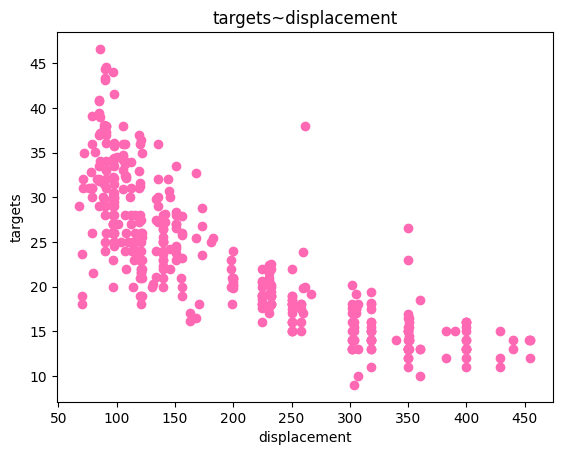

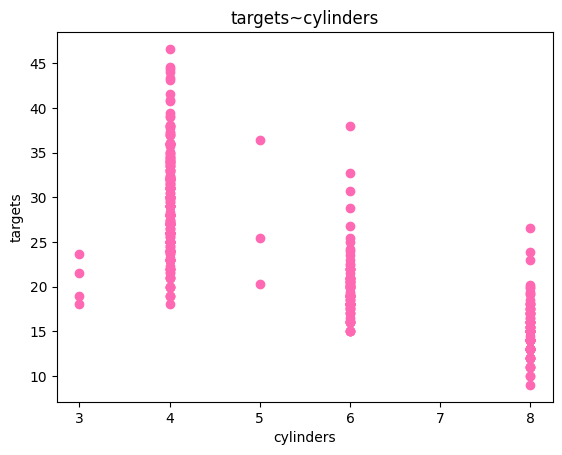

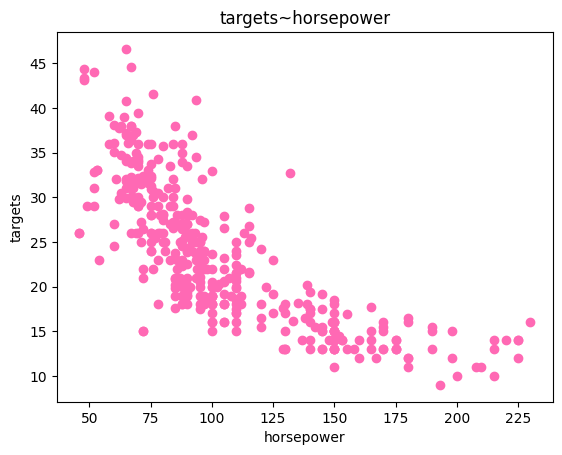

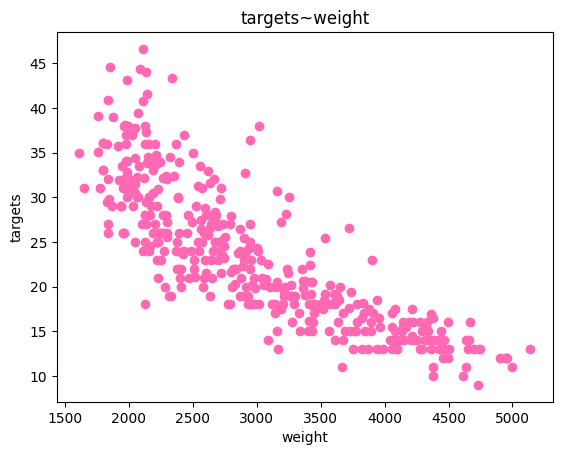

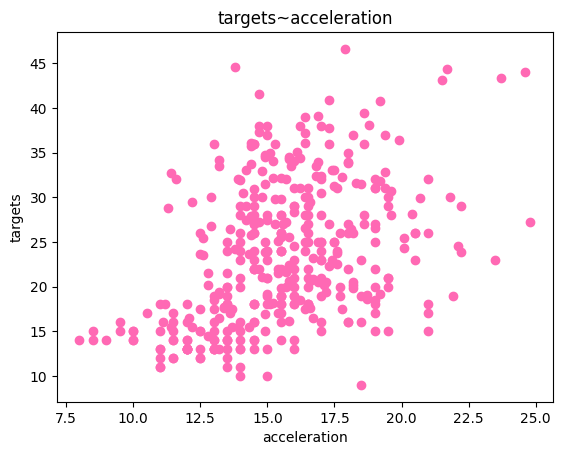

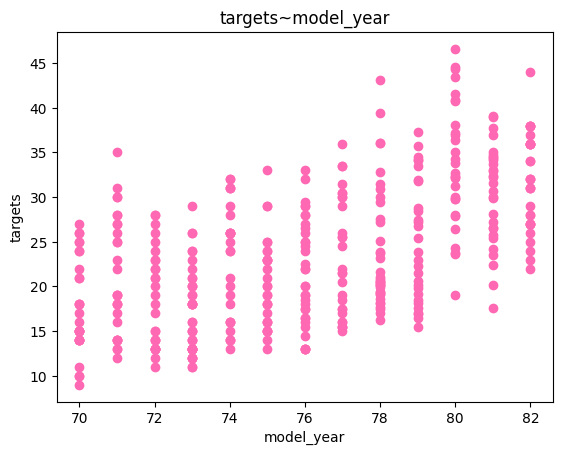

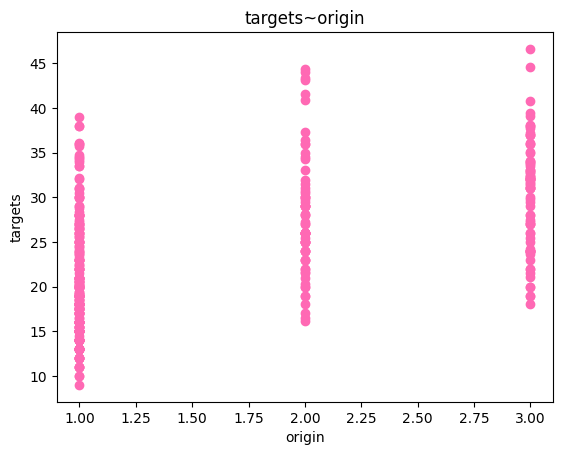

In [12]:
for i in ['displacement', 'cylinders', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']:
    plt.scatter(mpg_data2[i], mpg_data2['targets'], color='hotpink')
    plt.title(f'targets~{i}')
    plt.ylabel('targets')
    plt.xlabel(i)
    plt.show()

c:\Users\mazur\anaconda\envs\python11\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mazur\anaconda\envs\python11\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mazur\anaconda\envs\python11\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mazur\anaconda\envs\python11\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

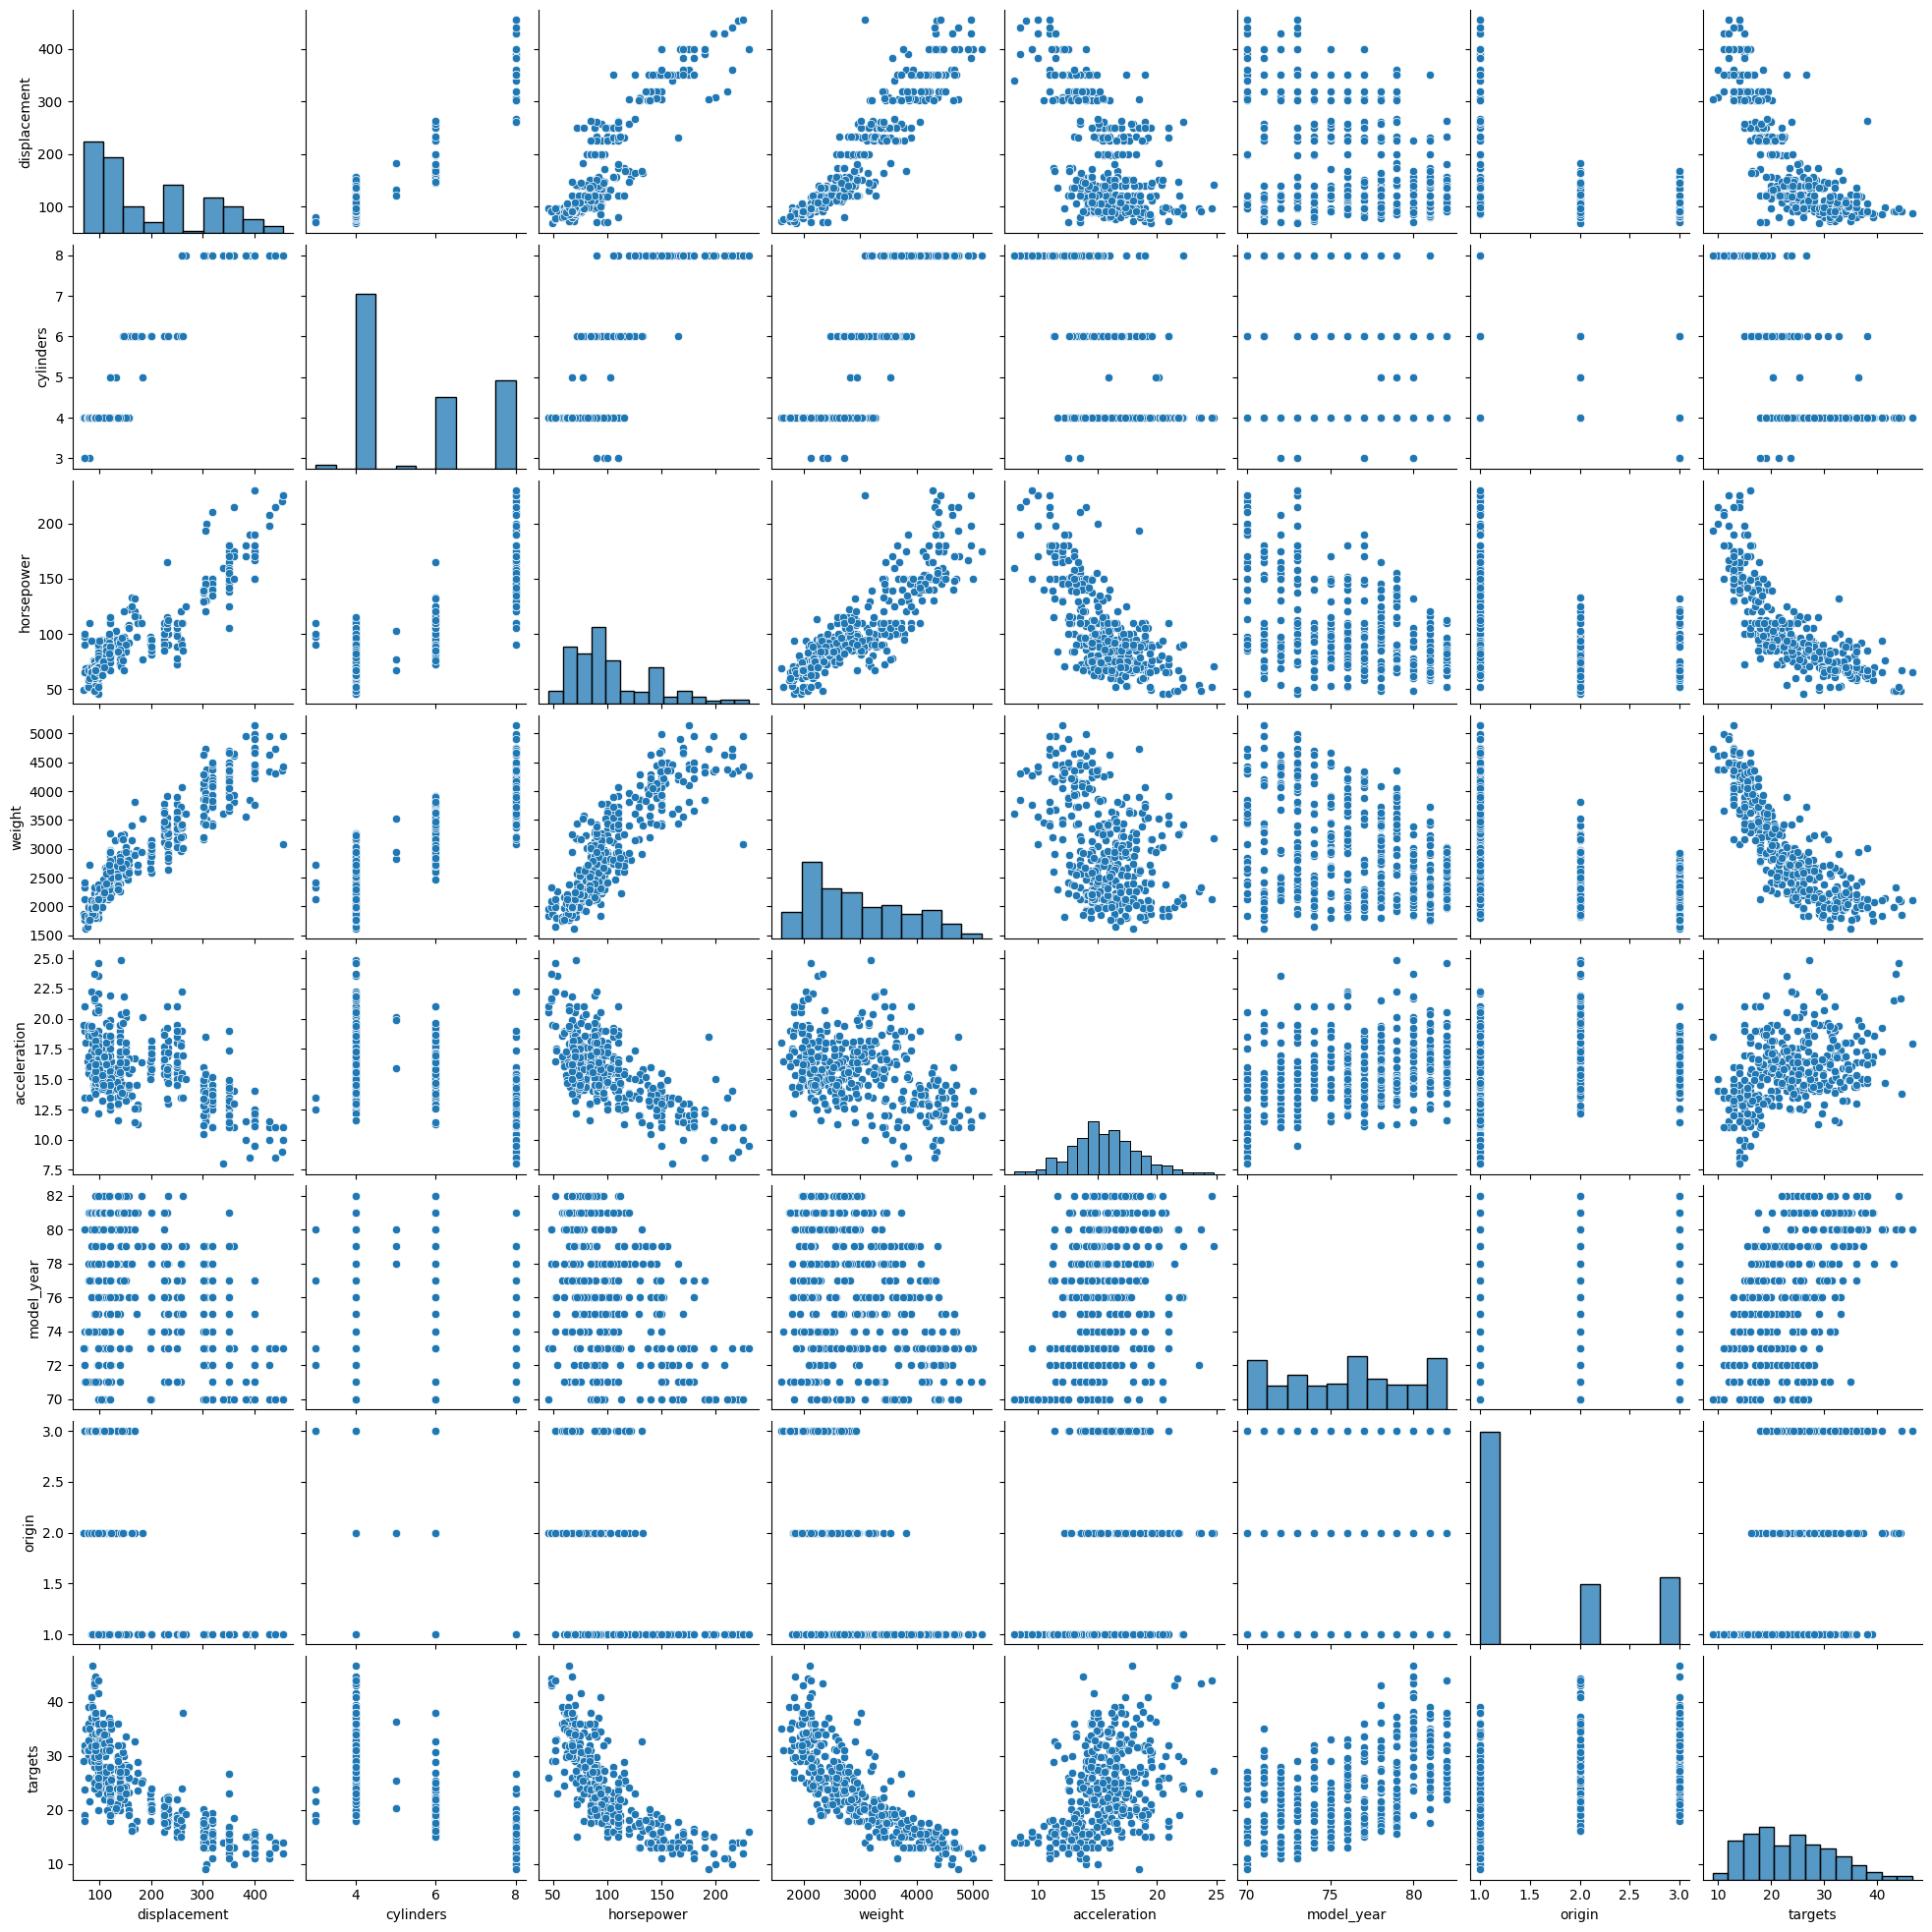

In [22]:
sns.pairplot(mpg_data2)

Based on this plot, values for displacement, horsepower and weight seem suspiciously correlated.

In [23]:
np.corrcoef(mpg_data2['displacement'], mpg_data2['horsepower'])

array([[1.       , 0.8957782],
       [0.8957782, 1.       ]])

In [24]:
np.corrcoef(mpg_data2['displacement'], mpg_data2['weight'])

array([[1.        , 0.93282415],
       [0.93282415, 1.        ]])

These two features are higly correlated with displacement, therefore displacement was not used in further analysis.

In [25]:
mpg_data2.drop('displacement', axis=1, inplace=True)

Additionally it was noted that 'weight and horsepower are higly correlated so one of them was deleted as well.

In [26]:
np.corrcoef(mpg_data2['weight'], mpg_data2['horsepower'])

array([[1.        , 0.86244236],
       [0.86244236, 1.        ]])

In [27]:
mpg_data2.drop('weight', axis=1, inplace=True)

In [28]:
mpg_data2.columns

Index(['cylinders', 'horsepower', 'acceleration', 'model_year', 'origin',
       'targets'],
      dtype='object')

## Data conversion

Normalization of numerical data, categorization of origin, which technically has a numerical value, but represents a categorical one.

In [375]:
rbase_data = mpg_data2.loc[:, ['cylinders', 'horsepower', 'acceleration', 'model_year']]
split_origin = pd.get_dummies(mpg_data2['origin'], prefix='origin')
rbase_data.loc[:, split_origin.columns] = split_origin
rtarget_data = mpg_data2['targets']
np.random.seed(1234)
rbase_data = (rbase_data - rbase_data.mean())/rbase_data.std()
rtarget_data = (rtarget_data - rtarget_data.mean())/rtarget_data.std()
rx_train, rx_test, ry_train, ry_test = train_test_split(rbase_data*1, rtarget_data*1)

In [377]:
rx_train.describe()

cylinders  horsepower  acceleration  model_year    origin_1  \
count  298.000000  298.000000    298.000000  298.000000  298.000000   
mean    -0.034568   -0.028498      0.036760    0.020878    0.003898   
std      0.989431    0.997763      0.998665    1.012119    0.999401   
min     -1.443132   -1.525380     -2.563048   -1.625381   -1.291101   
25%     -0.855244   -0.766667     -0.568625   -0.814049   -1.291101   
50%     -0.855244   -0.334985     -0.024691   -0.002718    0.772587   
75%      0.320532    0.410646      0.546439    0.808613    0.772587   
max      1.496308    3.288523      3.347698    1.619944    0.772587   

         origin_2    origin_3  
count  298.000000  298.000000  
mean     0.040388   -0.043280  
std      1.033500    0.966125  
min     -0.461387   -0.497018  
25%     -0.461387   -0.497018  
50%     -0.461387   -0.497018  
75%     -0.461387   -0.497018  
max      2.161930    2.006945

In [379]:
print('train shape:',rx_train.shape)
print('test shape:',rx_test.shape)

train shape: (298, 7)
test shape: (100, 7)


# Model creation

In [380]:
rx_train = np.asarray(rx_train).reshape((298, 7)).astype('float32')
rx_test = np.array(rx_test).reshape((100, 7)).astype('float32')

In [381]:
ry_train = np.asarray(ry_train)
ry_test = np.asarray(ry_test)

## Base model
With two layers: 
 - first having 128 neurons and activation function relu
 - second with 1 neuron and activation function sigmoid

As a base optimizer adam was taken. Loss function - mean square error. And as a comparison measure - mean absolute error.

In [382]:
model = models.Sequential()
model.add(Input(shape=(7,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
loss='mse',
metrics=['mae'])

In [383]:
model_mpg = model.fit(rx_train, ry_train, epochs=20, validation_data=(rx_test, ry_test))

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.2409 - mae: 0.9445 - val_loss: 1.0858 - val_mae: 0.9132
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0301 - mae: 0.8622 - val_loss: 0.9773 - val_mae: 0.8649
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9706 - mae: 0.8263 - val_loss: 0.8910 - val_mae: 0.8253
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8952 - mae: 0.8057 - val_loss: 0.8303 - val_mae: 0.7945
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7662 - mae: 0.7492 - val_loss: 0.7890 - val_mae: 0.7718
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7845 - mae: 0.7545 - val_loss: 0.7571 - val_mae: 0.7548
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7165 - mae: 0.7127 - val_loss: 0.7342 - val_mae: 0.7413
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7808 - mae: 0.7409 - val_loss: 0.7167 - val_mae: 0.7302
Epoch 9/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.7956 - ma

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7549 - mae: 0.7379 - val_loss: 0.7011 - val_mae: 0.7218
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.6786 - mae: 0.6852 - val_loss: 0.6899 - val_mae: 0.7140
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6829 - mae: 0.6872 - val_loss: 0.6789 - val_mae: 0.7077
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6895 - mae: 0.6863 - val_loss: 0.6705 - val_mae: 0.7021
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6591 - mae: 0.6784 - val_loss: 0.6643 - val_mae: 0.6972
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6443 - mae: 0.6638 - val_loss: 0.6567 - val_mae: 0.6945
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6698 - mae: 0.6811 - val_loss: 0.6500 - val_mae: 0.6921
Epoch 16/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6532 - mae: 0.6760 - val_loss: 0.6442 - val_mae: 0.6891
Epoch 17/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6192 - m

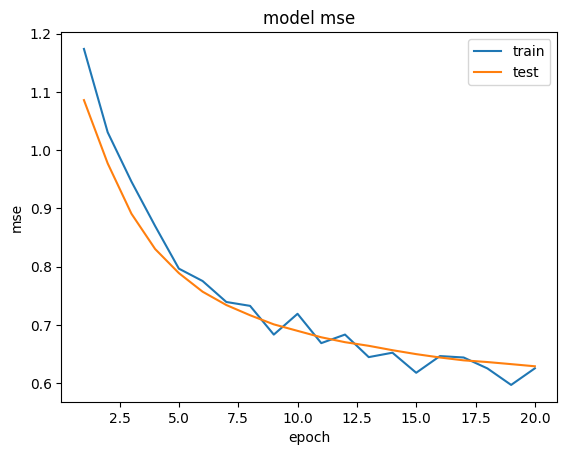

In [384]:
plt.plot(range(1,21),model_mpg.history['loss'])
plt.plot(range(1,21), model_mpg.history['val_loss'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

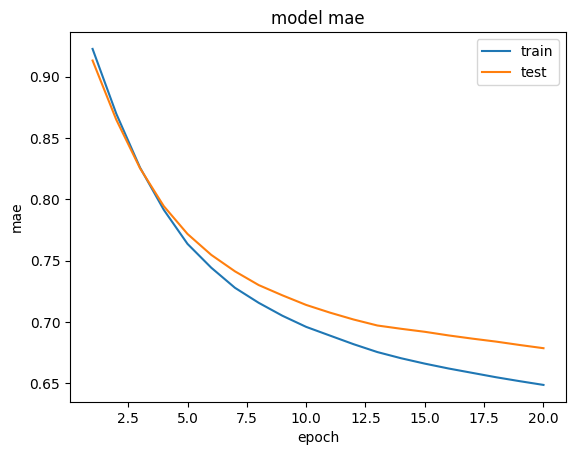

In [385]:
plt.plot(range(1,21), model_mpg.history['mae'])
plt.plot(range(1,21), model_mpg.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

As expected, with time MSE and MAE dicrease. Although, these two plots are rather exemplary and as they result from just a single run the values might be a little chaotic.

# Test number of epochs

In [185]:
def get_rmodel_base():
    model_optimizer = models.Sequential()
    model_optimizer.add(Input(shape=(7,)))
    model_optimizer.add(layers.Dense(128, activation='relu'))
    model_optimizer.add(layers.Dense(1, activation='sigmoid'))
    model_optimizer.compile(optimizer='adam',
    loss='mse',
    metrics=['mae'])
    return model_optimizer

In [191]:
n = 1
m = 10
train_acc_rtt = np.zeros((40,m))
test_acc_rtt = np.zeros((40,m))
train_loss_rtt = np.zeros((40,m))
test_loss_rtt = np.zeros((40,m))

In [192]:
for j in range(m):
    temp_model1 = get_rmodel_base()
    temp_model = temp_model1.fit(rx_train, ry_train, epochs=40, validation_data=(rx_test, ry_test))
    train_acc_rtt[:,j] = temp_model.history['mae']
    test_acc_rtt[:,j] = temp_model.history['val_mae']
    train_loss_rtt[:,j] = temp_model.history['loss']
    test_loss_rtt[:,j] = temp_model.history['val_loss']

Epoch 1/40


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.1247 - mae: 0.8860 - val_loss: 1.0506 - val_mae: 0.9063
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0559 - mae: 0.8707 - val_loss: 0.9320 - val_mae: 0.8540
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9303 - mae: 0.8218 - val_loss: 0.8497 - val_mae: 0.8146
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8215 - mae: 0.7653 - val_loss: 0.7957 - val_mae: 0.7865
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7857 - mae: 0.7503 - val_loss: 0.7590 - val_mae: 0.7661
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7447 - mae: 0.7332 - val_loss: 0.7326 - val_mae: 0.7510
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7058 - mae: 0.7064 - val_loss: 0.7117 - val_mae: 0.7394
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7372 - mae: 0.7204 - val_loss: 0.6970 - val_mae: 0.7300
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7061 - mae: 0.

In [ ]:
# np.save('rtt_train_mae', train_acc_rtt)
# np.save('rtt_train_mse', train_loss_rtt)
# np.save('rtt_test_mae', test_acc_rtt)
# np.save('rtt_test_mse', test_loss_rtt)

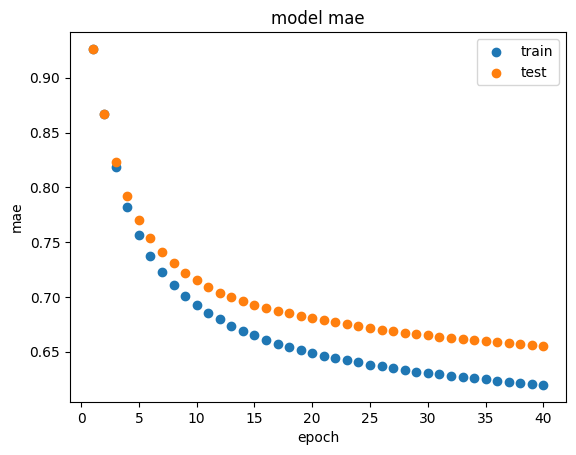

In [447]:
plt.scatter(range(1,41), train_acc_rtt.mean(axis=1))
plt.scatter(range(1,41), test_acc_rtt.mean(axis=1))
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

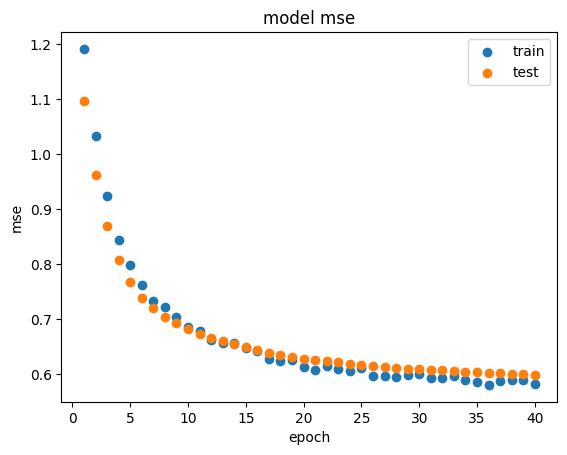

In [448]:
plt.scatter(range(1,41), train_loss_rtt.mean(axis=1))
plt.scatter(range(1,41), test_loss_rtt.mean(axis=1))
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

For these two plots comparing the results makes much more sense. It is clear that with time values of measure errors decrese.

The best number of epochs with respect to both metrics is 40. With this dataset a little bigger number of epochs isn't that problematic as the learing process goes pretty fast.

# Test number of neurons

In [201]:
def get_rmodel_neurons(n_neurons: int):
    model_optimizer = models.Sequential()
    model_optimizer.add(Input(shape=(7,)))
    model_optimizer.add(layers.Dense(n_neurons, activation='relu'))
    model_optimizer.add(layers.Dense(1, activation='sigmoid'))
    model_optimizer.compile(optimizer='adam',
    loss='mse',
    metrics=['mae'])
    return model_optimizer

In [203]:
n=10
m=20
train_acc_rn = np.zeros((n,m))
test_acc_rn = np.zeros((n,m))
train_loss_rn = np.zeros((n,m))
test_loss_rn = np.zeros((n,m))
k=0
for i in range(n):
    for j in range(m):
        temp_model1 = get_rmodel_neurons(2**(i+1))
        temp_model = temp_model1.fit(rx_train, ry_train, epochs=15, validation_data=(rx_test, ry_test))
        train_acc_rn[k,j] = temp_model.history['mae'][-1]
        test_acc_rn[k,j] = temp_model.history['val_mae'][-1]
        train_loss_rn[k,j] = temp_model.history['loss'][-1]
        test_loss_rn[k,j] = temp_model.history['val_loss'][-1]
    k += 1

Epoch 1/15


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.4115 - mae: 0.9994 - val_loss: 1.4306 - val_mae: 1.0537
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4784 - mae: 1.0209 - val_loss: 1.3955 - val_mae: 1.0409
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3793 - mae: 0.9843 - val_loss: 1.3606 - val_mae: 1.0279
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4082 - mae: 0.9895 - val_loss: 1.3241 - val_mae: 1.0144
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3625 - mae: 0.9899 - val_loss: 1.2882 - val_mae: 1.0008
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3450 - mae: 0.9958 - val_loss: 1.2531 - val_mae: 0.9872
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2913 - mae: 0.9615 - val_loss: 1.2197 - val_mae: 0.9739
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1811 - mae: 0.9286 - val_loss: 1.1897 - val_mae: 0.9616
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1946 - mae: 0.9286 - v

In [212]:
# np.save('rn_train_mae', train_acc_rn)
# np.save('rn_train_mse', train_loss_rn)
# np.save('rn_test_mae', test_acc_rn)
# np.save('rn_test_mse', test_loss_rn)

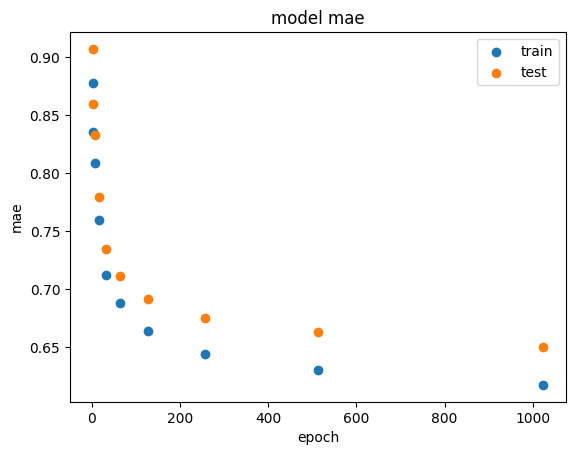

In [449]:
plt.scatter([2**(i+1) for i in range(10)], train_acc_rn.mean(axis=1))
plt.scatter([2**(i+1) for i in range(10)], test_acc_rn.mean(axis=1))
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

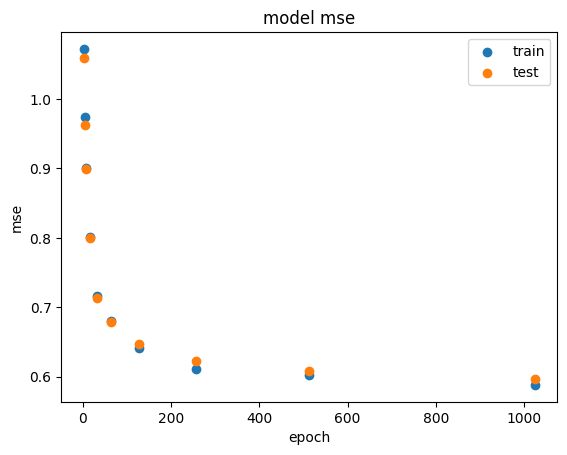

In [450]:
plt.scatter([2**(i+1) for i in range(10)], train_loss_rn.mean(axis=1))
plt.scatter([2**(i+1) for i in range(10)], test_loss_rn.mean(axis=1))
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

For number of neurons similarly like before - more neurons seem to improve the fit of the model both to train and test set.

Out of checked values, model seems to fit the best for $2^{10}$ of neurons.

# Test number of layers

In [386]:
def get_rmodel_layers(n_layers: int):
    model_optimizer = models.Sequential()
    model_optimizer.add(Input(shape=(7,)))
    for i in range(n_layers):
        model_optimizer.add(layers.Dense(64, activation='relu'))
    model_optimizer.add(layers.Dense(1, activation='sigmoid'))
    model_optimizer.compile(optimizer='adam',
    loss='mse',
    metrics=['mae'])
    return model_optimizer

In [387]:
n=20
m=10
train_acc_rl = np.zeros((n,m))
test_acc_rl = np.zeros((n,m))
train_loss_rl = np.zeros((n,m))
test_loss_rl = np.zeros((n,m))
k=0
for i in range(n):
    for j in range(m):
        temp_model1 = get_rmodel_layers(n)
        temp_model = temp_model1.fit(rx_train, ry_train, epochs=15, validation_data=(rx_test, ry_test))
        train_acc_rl[k,j] = temp_model.history['mae'][-1]
        test_acc_rl[k,j] = temp_model.history['val_mae'][-1]
        train_loss_rl[k,j] = temp_model.history['loss'][-1]
        test_loss_rl[k,j] = temp_model.history['val_loss'][-1]
    k += 1

Epoch 1/15


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 1.1762 - mae: 0.9120 - val_loss: 1.0930 - val_mae: 0.9122
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9486 - mae: 0.8102 - val_loss: 0.8947 - val_mae: 0.7860
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8090 - mae: 0.7590 - val_loss: 0.7814 - val_mae: 0.7580
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7413 - mae: 0.7110 - val_loss: 0.7626 - val_mae: 0.7296
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6778 - mae: 0.6678 - val_loss: 0.7631 - val_mae: 0.7424
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7293 - mae: 0.7158 - val_loss: 0.7609 - val_mae: 0.7539
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7407 - mae: 0.7086 - val_loss: 0.7428 - val_mae: 0.7330
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6938 - mae: 0.6884 - val_loss: 0.7132 - val_mae: 0.7208
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6914 - mae: 0.

In [388]:
# np.save('rrl_train_mae', train_acc_rl)
# np.save('rrl_train_mse', train_loss_rl)
# np.save('rrl_test_mae', test_acc_rl)
# np.save('rrl_test_mse', test_loss_rl)

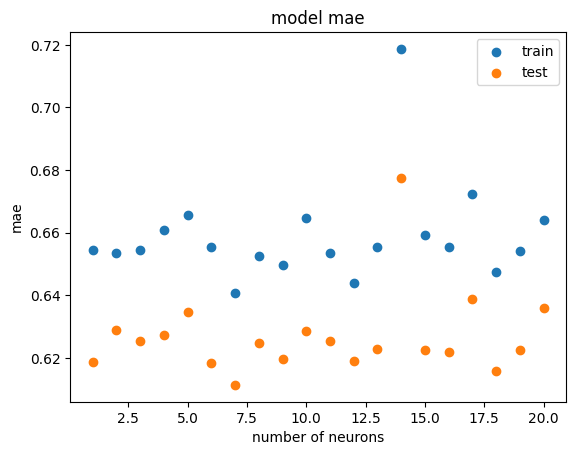

In [395]:
plt.scatter(range(1,n+1), test_acc_rl.mean(axis=1))
plt.scatter(range(1, n+1), train_acc_rl.mean(axis=1))
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('number of neurons')
plt.legend(['train', 'test'])
plt.show()

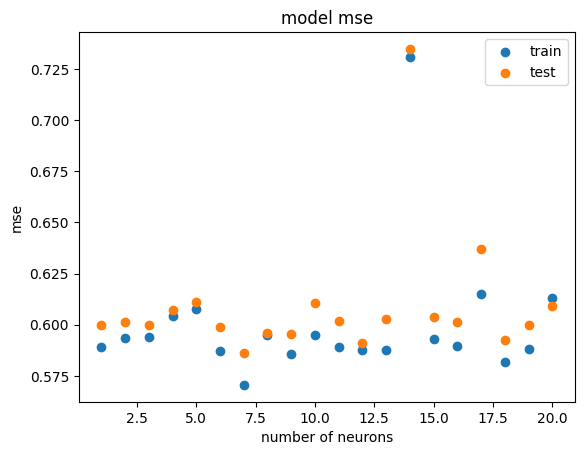

In [396]:
plt.scatter(range(1,n+1), train_loss_rl.mean(axis=1))
plt.scatter(range(1,n+1), test_loss_rl.mean(axis=1))
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('number of neurons')
plt.legend(['train', 'test'])
plt.show()

It's difficult to state for which number of layers the results are the best. The values for 7 layers seem to be the lowest but there is no clear indication that this model should be considered the best. Due to e.g. greater differences between train and test set results.

# Comparison of the best models in each category

## Optimal epoch number

In [391]:
rmodel_e = models.Sequential()
rmodel_e.add(Input(shape=(7,)))
rmodel_e.add(layers.Dense(128, activation='relu'))
rmodel_e.add(layers.Dense(1, activation='sigmoid'))
rmodel_e.compile(optimizer='adam',
loss='mse',
metrics=['mae'])

In [392]:
rmodel_e1 = rmodel_e.fit(rx_train, ry_train, epochs=40, validation_data=(rx_test, ry_test))

Epoch 1/40


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 1.4930 - mae: 1.0281 - val_loss: 1.2622 - val_mae: 0.9931
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2268 - mae: 0.9234 - val_loss: 1.0914 - val_mae: 0.9264
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0972 - mae: 0.8802 - val_loss: 0.9486 - val_mae: 0.8650
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9328 - mae: 0.8131 - val_loss: 0.8468 - val_mae: 0.8176
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8089 - mae: 0.7513 - val_loss: 0.7832 - val_mae: 0.7838
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7345 - mae: 0.7306 - val_loss: 0.7438 - val_mae: 0.7598
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8432 - mae: 0.7707 - val_loss: 0.7184 - val_mae: 0.7431
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6591 - mae: 0.6654 - val_loss: 0.7012 - val_mae: 0.7307
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7290 - mae: 0

## Best neuron number

In [393]:
rmodel_n = models.Sequential()
rmodel_n.add(Input(shape=(7,)))
rmodel_n.add(layers.Dense(2**10, activation='relu'))
rmodel_n.add(layers.Dense(1, activation='sigmoid'))
rmodel_n.compile(optimizer='adam',
loss='mse',
metrics=['mae'])

In [394]:
rmodel_n1 = rmodel_n.fit(rx_train, ry_train, epochs=15, validation_data=(rx_test, ry_test))

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 1.1838 - mae: 0.9154 - val_loss: 0.8767 - val_mae: 0.8289
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8741 - mae: 0.7896 - val_loss: 0.7431 - val_mae: 0.7554
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7764 - mae: 0.7470 - val_loss: 0.6979 - val_mae: 0.7210
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6929 - mae: 0.7049 - val_loss: 0.6717 - val_mae: 0.7017
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5976 - mae: 0.6364 - val_loss: 0.6541 - val_mae: 0.6909
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6909 - mae: 0.6886 - val_loss: 0.6384 - val_mae: 0.6856
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6458 - mae: 0.6609 - val_loss: 0.6299 - val_mae: 0.6797
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6296 - mae: 0.6526 - val_loss: 0.6240 - val_mae: 0.6735
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.634

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5880 - mae: 0.6261 - val_loss: 0.6045 - val_mae: 0.6599
Epoch 13/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.5660 - mae: 0.6081 - val_loss: 0.6025 - val_mae: 0.6569
Epoch 14/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5109 - mae: 0.5748 - val_loss: 0.6008 - val_mae: 0.6534
Epoch 15/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6071 - mae: 0.6240 - val_loss: 0.5979 - val_mae: 0.6519


## Best layer number

In [397]:
rmodel_l = models.Sequential()
rmodel_l.add(Input(shape=(7,)))
for i in range(6):
        rmodel_l.add(layers.Dense(64, activation='relu'))
rmodel_l.add(layers.Dense(1, activation='sigmoid'))
rmodel_l.compile(optimizer='adam',
loss='mse',
metrics=['mae'])

In [398]:
rmodel_l1 = rmodel_l.fit(rx_train, ry_train, epochs=15, validation_data=(rx_test, ry_test))

Epoch 1/15


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 1.2209 - mae: 0.9338 - val_loss: 1.0441 - val_mae: 0.8904
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.9278 - mae: 0.8215 - val_loss: 0.8150 - val_mae: 0.7682
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7754 - mae: 0.7321 - val_loss: 0.7147 - val_mae: 0.7171
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6596 - mae: 0.6745 - val_loss: 0.6497 - val_mae: 0.6769
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6455 - mae: 0.6667 - val_loss: 0.6105 - val_mae: 0.6538
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5728 - mae: 0.6191 - val_loss: 0.5971 - val_mae: 0.6510
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6889 - mae: 0.6752 - val_loss: 0.5954 - val_mae: 0.6394
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5649 - mae: 0.6121 - val_loss: 0.5903 - val_mae: 0.6384
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6014 - mae: 0.

## Combo

Combines all the best attributes. 

<b>Warning:</b> it doesn't mean this model is the best one. It combines parameters that proved to worked well separately appllied to the base model.

In [399]:
rmodel_all = models.Sequential()
rmodel_all.add(Input(shape=(7,)))
for i in range(6):
        rmodel_all.add(layers.Dense(2**10, activation='relu'))
rmodel_all.add(layers.Dense(1, activation='sigmoid'))
rmodel_all.compile(optimizer='adam',
loss='mse',
metrics=['mae'])

In [400]:
rmodel_all1 = rmodel_all.fit(rx_train, ry_train, epochs=40, validation_data=(rx_test, ry_test))

Epoch 1/40


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - loss: 0.9661 - mae: 0.8240 - val_loss: 0.6601 - val_mae: 0.7158
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 0.6537 - mae: 0.6690 - val_loss: 0.6639 - val_mae: 0.7228
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.6134 - mae: 0.6351 - val_loss: 0.6342 - val_mae: 0.6975
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.6088 - mae: 0.6488 - val_loss: 0.6830 - val_mae: 0.7189
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.5963 - mae: 0.6278 - val_loss: 0.6137 - val_mae: 0.6635
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.6073 - mae: 0.6359 - val_loss: 0.6104 - val_mae: 0.6612
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.5706 - mae: 0.6167 - val_loss: 0.6032 - val_mae: 0.6623
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.5733 - mae: 0.6149 - val_loss: 0.5965 - val_mae: 0.6526
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.5923 

## Comparison

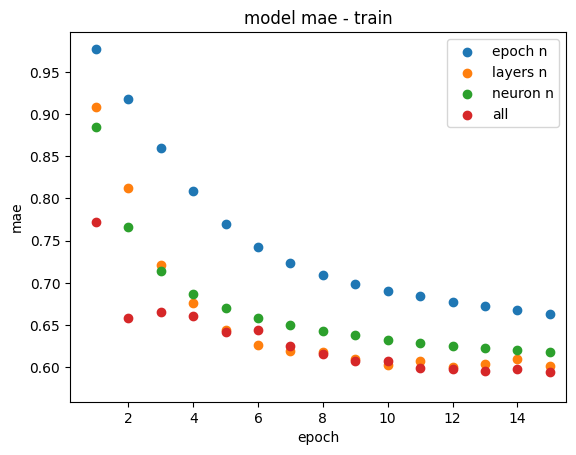

In [413]:
plt.scatter(range(1,41), rmodel_e1.history['mae'], label='epoch n')
plt.scatter(range(1, 16), rmodel_l1.history['mae'], label='layers n')
plt.scatter(range(1, 16), rmodel_n1.history['mae'], label='neuron n')
plt.scatter(range(1, 41), rmodel_all1.history['mae'], label='all')
plt.legend()
plt.title('model mae - train')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.xlim([.2, 15.5])
plt.show()

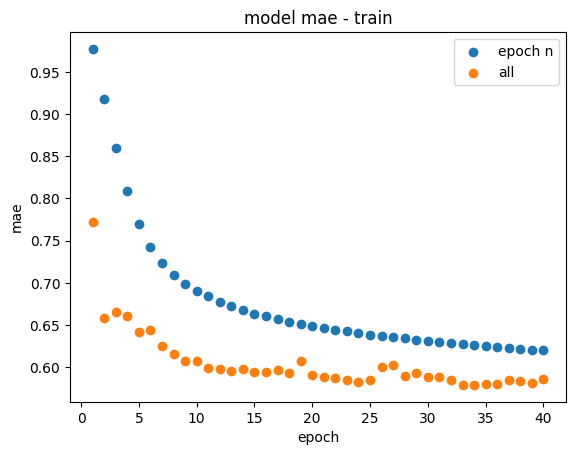

In [414]:
plt.scatter(range(1,41), rmodel_e1.history['mae'], label='epoch n')
plt.scatter(range(1, 41), rmodel_all1.history['mae'], label='all')
plt.legend()
plt.title('model mae - train')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show()

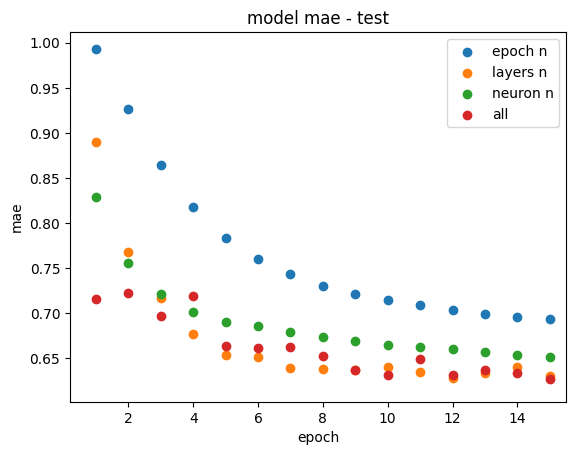

In [406]:
plt.scatter(range(1,41), rmodel_e1.history['val_mae'], label='epoch n')
plt.scatter(range(1,16), rmodel_l1.history['val_mae'], label='layers n')
plt.scatter(range(1,16), rmodel_n1.history['val_mae'], label='neuron n')
plt.scatter(range(1,41), rmodel_all1.history['val_mae'], label='all')
plt.legend()
plt.title('model mae - test')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.xlim([.2, 15.5])
plt.show()

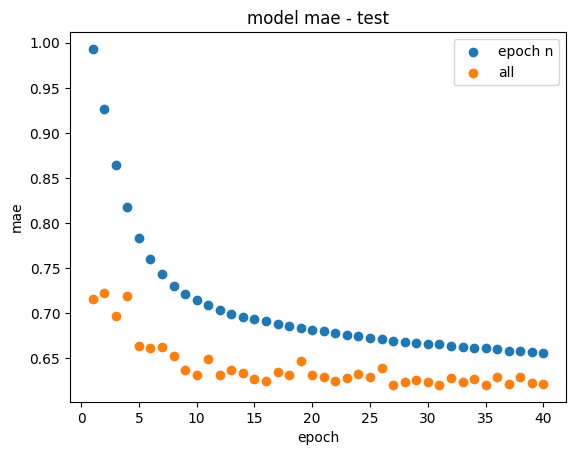

In [415]:
plt.scatter(range(1,41), rmodel_e1.history['val_mae'], label='epoch n')
plt.scatter(range(1,41), rmodel_all1.history['val_mae'], label='all')
plt.legend()
plt.title('model mae - test')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show()

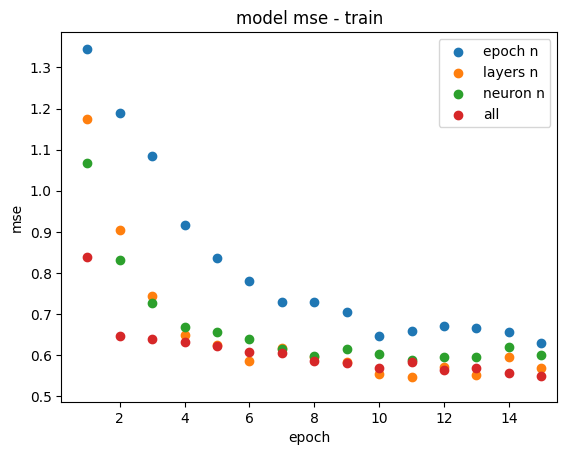

In [416]:
plt.scatter(range(1,41), rmodel_e1.history['loss'], label='epoch n')
plt.scatter(range(1,16), rmodel_l1.history['loss'], label='layers n')
plt.scatter(range(1,16), rmodel_n1.history['loss'], label='neuron n')
plt.scatter(range(1,41), rmodel_all1.history['loss'], label='all')
plt.title('model mse - train')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.xlim([.2, 15.5])
plt.legend()
plt.show()

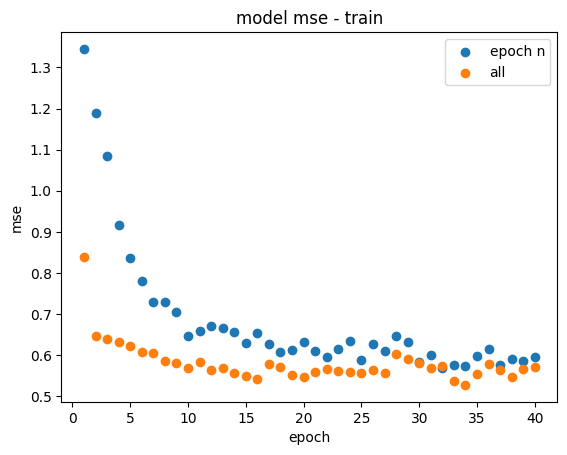

In [417]:
plt.scatter(range(1,41), rmodel_e1.history['loss'], label='epoch n')
plt.scatter(range(1,41), rmodel_all1.history['loss'], label='all')
plt.title('model mse - train')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend()
plt.show()

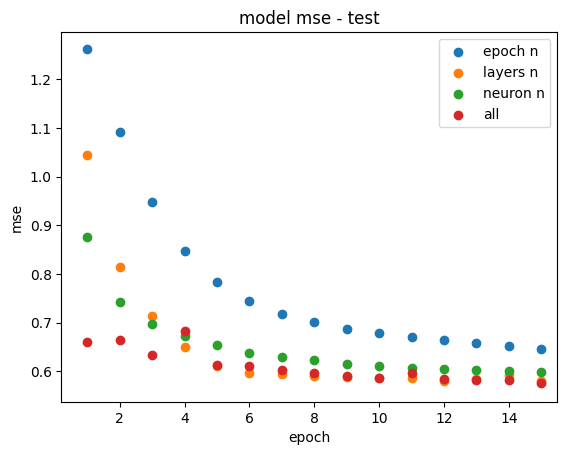

In [418]:
plt.scatter(range(1,41), rmodel_e1.history['val_loss'], label='epoch n')
plt.scatter(range(1,16), rmodel_l1.history['val_loss'], label='layers n')
plt.scatter(range(1,16), rmodel_n1.history['val_loss'], label='neuron n')
plt.scatter(range(1,41), rmodel_all1.history['val_loss'], label='all')
plt.title('model mse - test')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.xlim([.2, 15.5])
plt.legend()
plt.show()

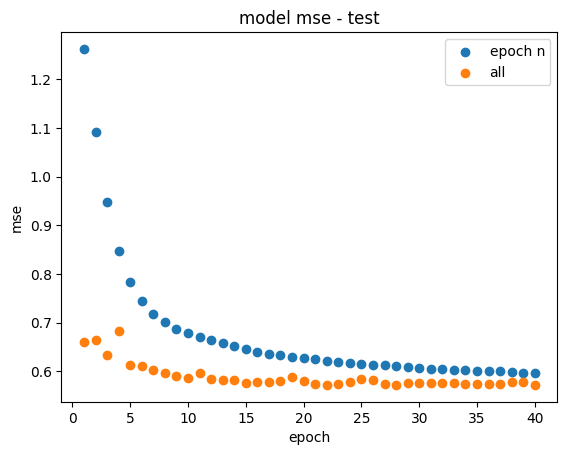

In [419]:
plt.scatter(range(1,41), rmodel_e1.history['val_loss'], label='epoch n')
plt.scatter(range(1,41), rmodel_all1.history['val_loss'], label='all')
plt.title('model mse - test')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [461]:
e1_pd = pd.DataFrame(rmodel_e1.history)
print('results for optimal epoch number: \n\n', e1_pd.iloc[-1], '\n\n')
n1_pd = pd.DataFrame(rmodel_n1.history)
print('results for optimal neuron number: \n\n', n1_pd.iloc[-1], '\n\n')
l1_pd = pd.DataFrame(rmodel_l1.history)
print('results for best layers number: \n\n', l1_pd.iloc[-1], '\n\n')
all1_pd = pd.DataFrame(rmodel_all1.history)
print('results for all best parameterss: \n\n', all1_pd.iloc[-1], '\n\n')

results for optimal epoch number: 

 loss        0.595601
mae         0.620109
val_loss    0.597150
val_mae     0.656050
Name: 39, dtype: float64 


results for optimal neuron number: 

 loss        0.599815
mae         0.617870
val_loss    0.597873
val_mae     0.651858
Name: 14, dtype: float64 


results for best layers number: 

 loss        0.568969
mae         0.601079
val_loss    0.581038
val_mae     0.630535
Name: 14, dtype: float64 


results for all best parameterss: 

 loss        0.571203
mae         0.586760
val_loss    0.572089
val_mae     0.621905
Name: 39, dtype: float64 




Based on the plots the following conclusions can be formed:
 - Even, though the course of learing for different models is visibly different, the end values of mae and mse are pretty similar.
 - As expected model fits better to the train data and small differences in performance can be denoted with respect to the test set.
 - Bigger differences between train and test set are more visible for mae than for mse.
 - In terms of mse values model combining all the best parameters seems to work the best. Even though we get smaller values for train set with best layer number we have a bigger difference with test set.
 - Looking at the mae values it can be seen that the same model fits best but with greater differences with respect to test set.